#imports

In [1]:
import torch
import random
from torch import nn
from torch.utils.data import TensorDataset, DataLoader
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
%matplotlib inline
import time
from sklearn.decomposition import PCA

import utils
import sin_task
import K_Bit_Flipflop_task

from Models import Three_Bodies_RNN, Full_Rank_RNN, Low_Rank_RNN, Low_Rank_Three_Way_RNN

In [2]:
# Some more definitions for plotting

colors = np.array([[0.1254902 , 0.29019608, 0.52941176],
       [0.80784314, 0.36078431, 0.        ],
       [0.30588235, 0.60392157, 0.02352941],
       [0.64313725, 0.        , 0.        ]])

figsize = (8, 3)

In [3]:
DEVICE = "cuda" if torch.cuda.is_available() else "cpu"

In [4]:
##############################################################
def mount_colab():
  from google.colab import drive
  drive.mount('/content/drive')

  drive_path = '/content/drive/MyDrive'
  colab_path = '.'

  !cp -r {drive_path} {colab_path}

In [5]:
SEED = 3150
random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)

#Three Way Model
$h_t=\sigma(h_{t-1}^{T}\cdot𝓦\cdot h_{t-1} + I\cdot u_t)$

#Experiments

##Sinus prediction task

###Train

In [ ]:
T=100

# decide on hyperparameters
input_size=1
output_size=1
hidden_dim=30

# instantiate an double_body_RNN
sin_three_bodies_rnn = Three_Bodies_RNN(input_size, output_size, hidden_dim,torch.sigmoid, task = "Sin").to(DEVICE)

# MSE loss and SGD optimizer with a learning rate
criterion = nn.MSELoss().to(DEVICE)
optimizer = torch.optim.Adam(sin_three_bodies_rnn.parameters(), lr=1e-04)

# train the rnn and monitor results
n_steps = 300
n_batch = 1000
batch_size = 128

Inputs , Targets = gen_data(n_batch,T)

losses = sin_three_bodies_rnn.train(Inputs,Targets,n_steps,optimizer,criterion,batch_size,T)

  0%|          | 0/3000 [00:00<?, ?it/s]

0 /10 --- loss = 0.262650
Loss:  0.2626495361328125


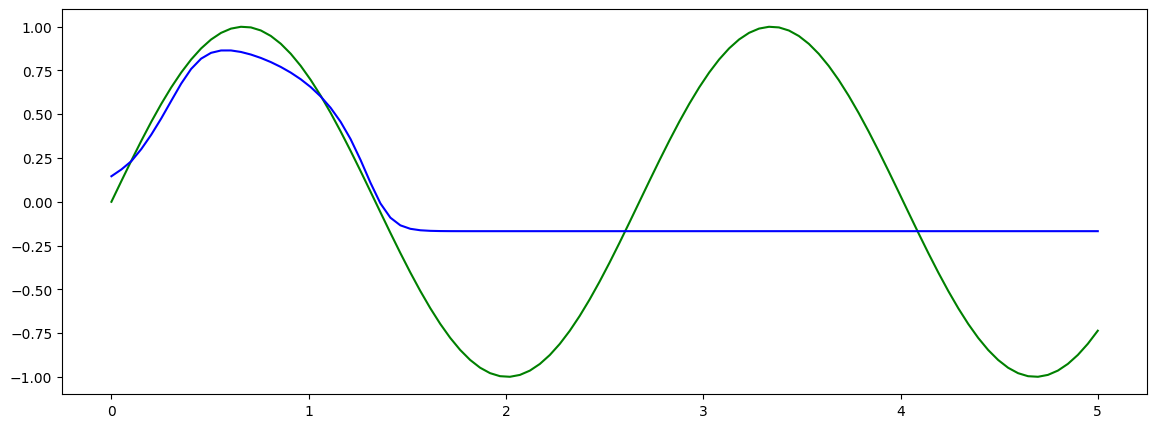

 10%|█         | 300/3000 [03:58<35:04,  1.28it/s]

1 /10 --- loss = 0.249427
Loss:  0.24942682683467865


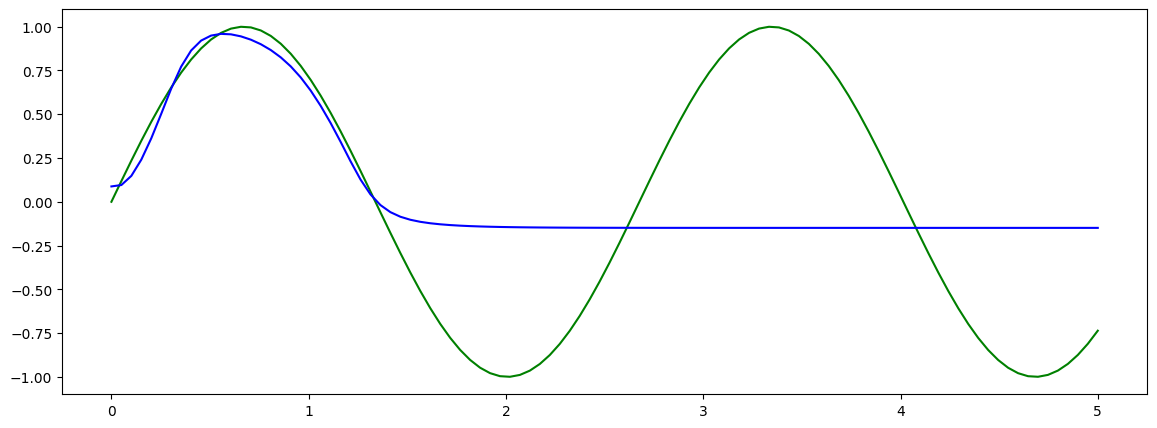

 20%|██        | 600/3000 [07:57<32:27,  1.23it/s]

2 /10 --- loss = 0.463555
Loss:  0.4635545313358307


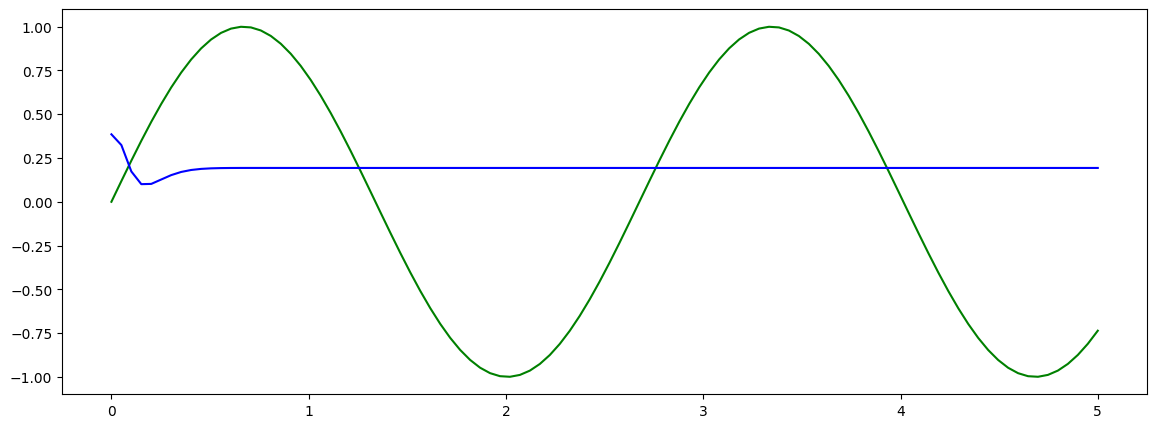

 30%|███       | 900/3000 [11:56<27:58,  1.25it/s]

3 /10 --- loss = 0.444676
Loss:  0.4446755051612854


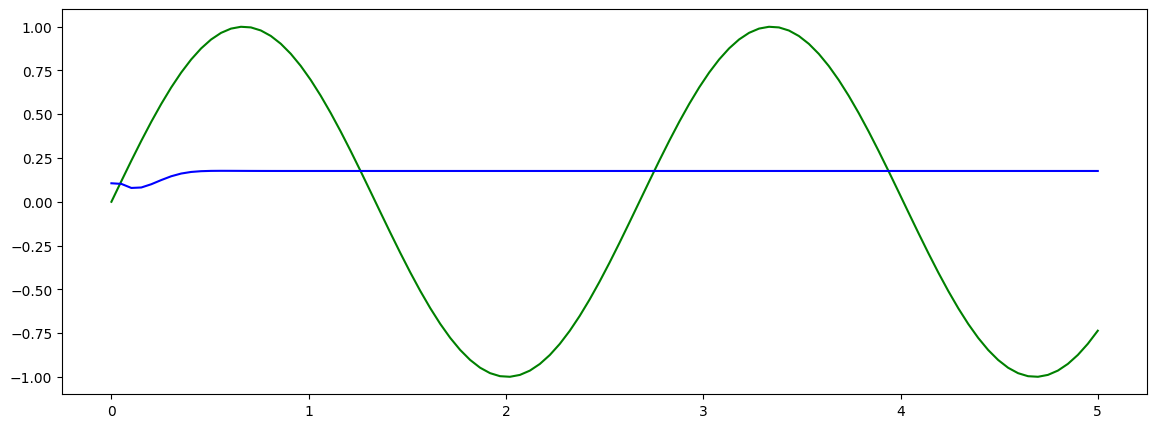

 40%|████      | 1200/3000 [16:01<24:36,  1.22it/s]

4 /10 --- loss = 0.148452
Loss:  0.14845243096351624


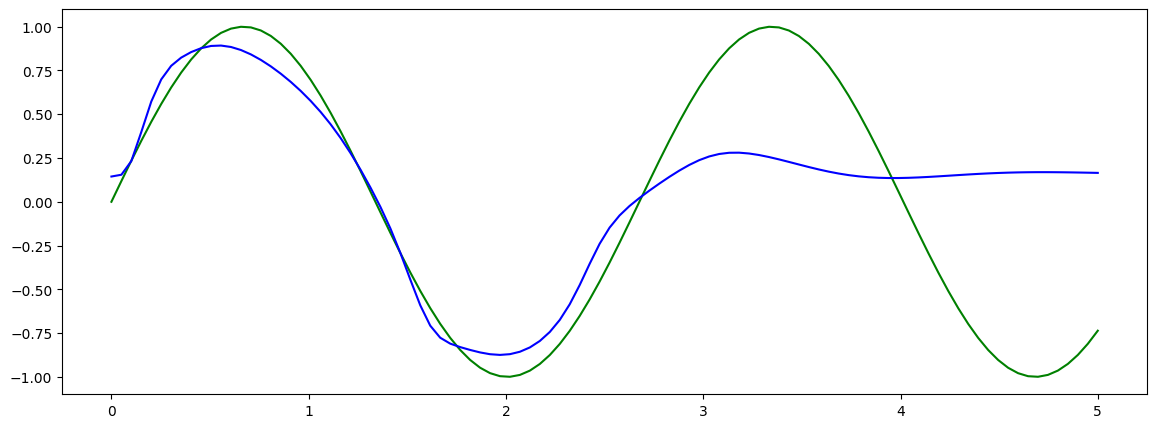

 50%|█████     | 1500/3000 [20:04<19:27,  1.29it/s]

5 /10 --- loss = 0.018555
Loss:  0.018554899841547012


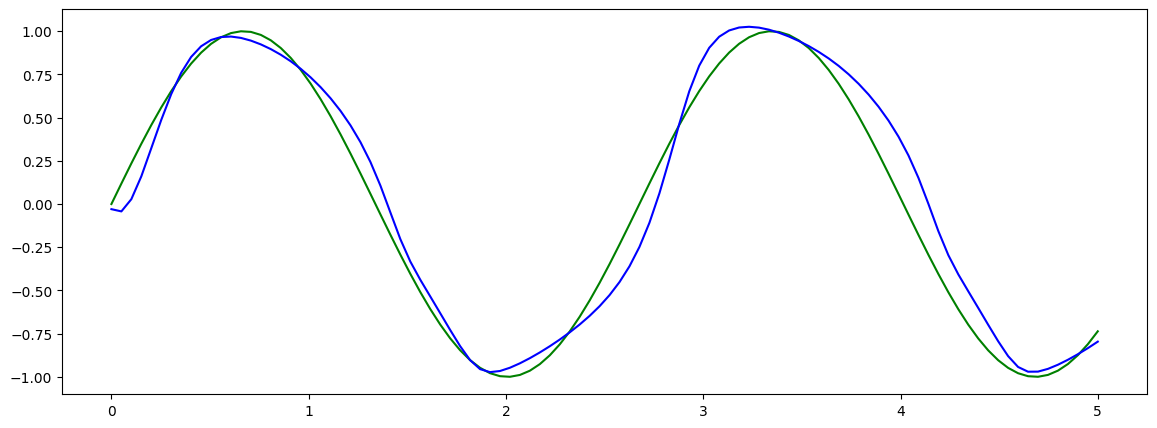

 60%|██████    | 1800/3000 [24:00<15:46,  1.27it/s]

6 /10 --- loss = 0.003949
Loss:  0.003948632162064314


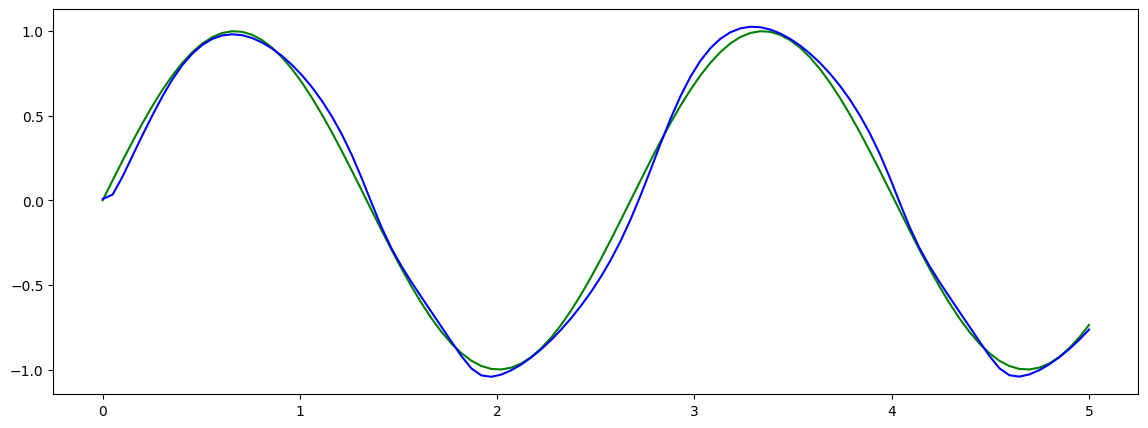

 70%|███████   | 2100/3000 [27:59<12:00,  1.25it/s]

7 /10 --- loss = 0.005597
Loss:  0.005596766248345375


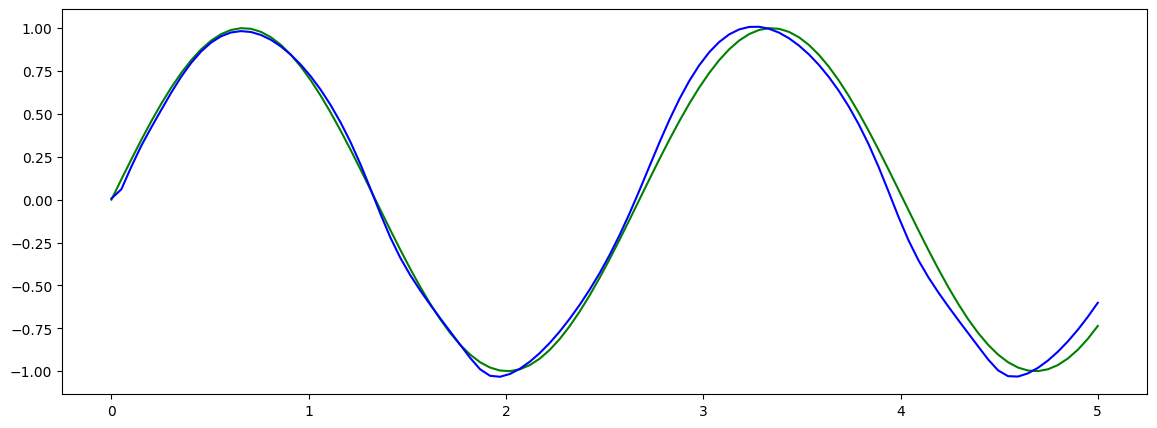

 80%|████████  | 2400/3000 [31:58<08:04,  1.24it/s]

8 /10 --- loss = 0.009513
Loss:  0.009512779302895069


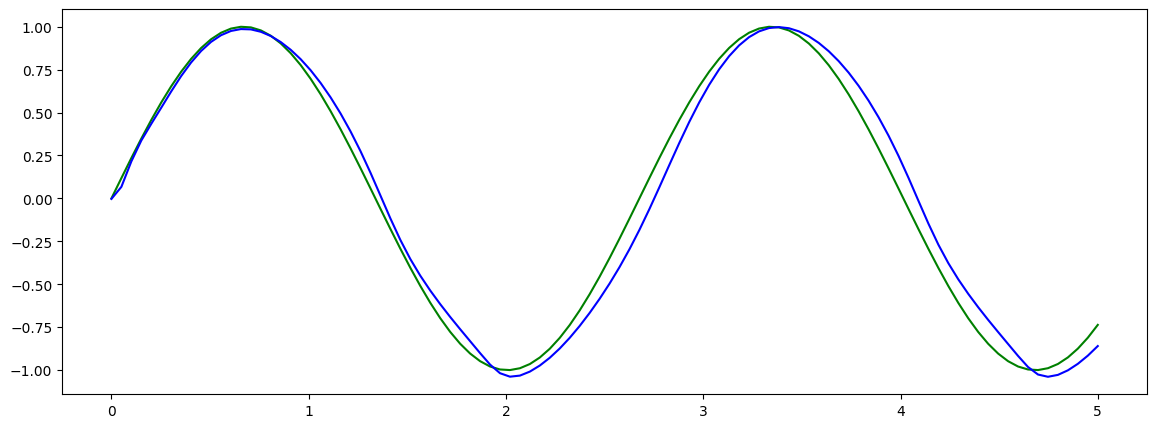

 90%|█████████ | 2700/3000 [35:57<04:00,  1.25it/s]

9 /10 --- loss = 0.001313
Loss:  0.001312607666477561


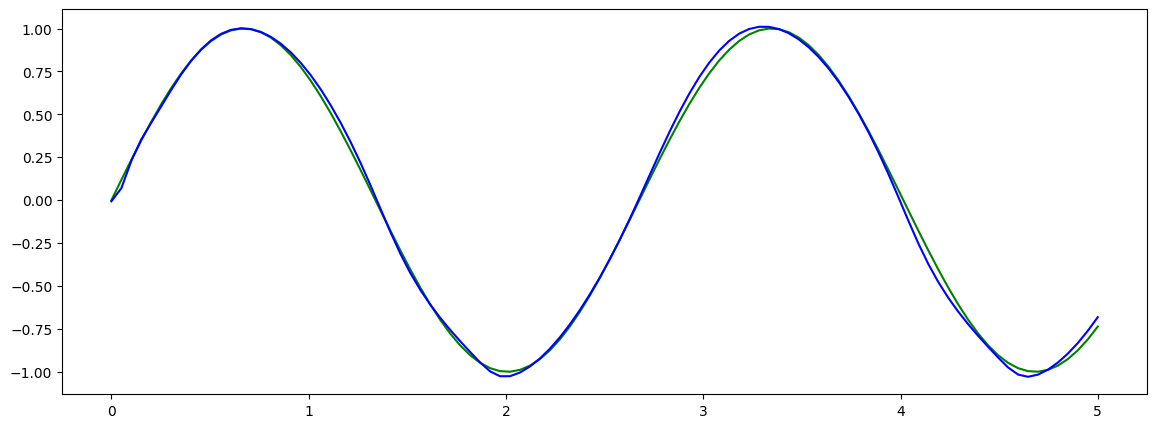

100%|██████████| 3000/3000 [39:54<00:00,  1.25it/s]

Loss:  0.0020816230680793524


In [24]:
n_steps = 3000
losses = sin_three_bodies_rnn.train(Inputs,Targets,n_steps,optimizer,criterion,batch_size,T)

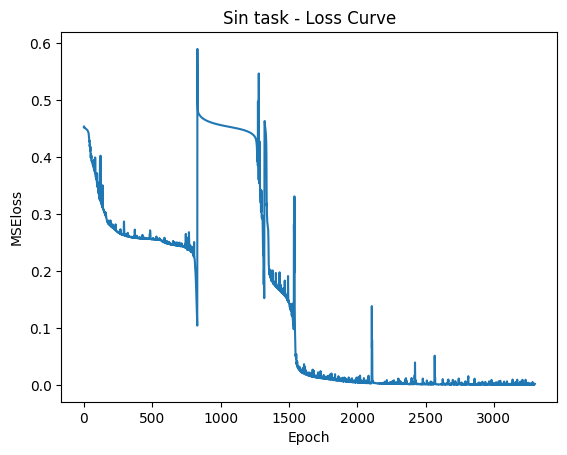

In [34]:
_=plt.xlabel("Epoch")
_=plt.ylabel("MSEloss")
_=plt.title("Sin task - Loss Curve")
_=plt.plot(losses)

In [27]:
with torch.no_grad():
  prediction = sin_three_bodies_rnn(Inputs,None)[0]

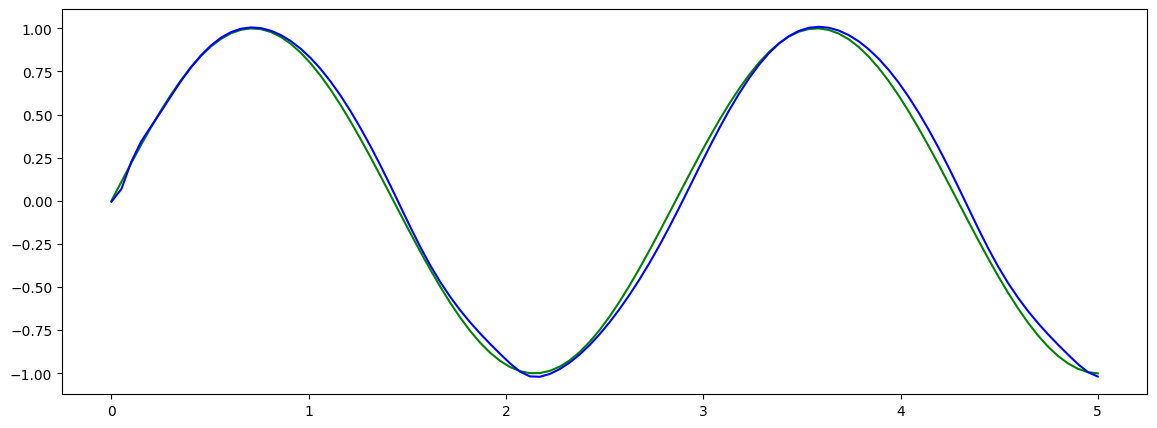

In [32]:
plot_sin(T,Targets.cpu(),prediction.cpu(),loss=None,idx=30)

test results

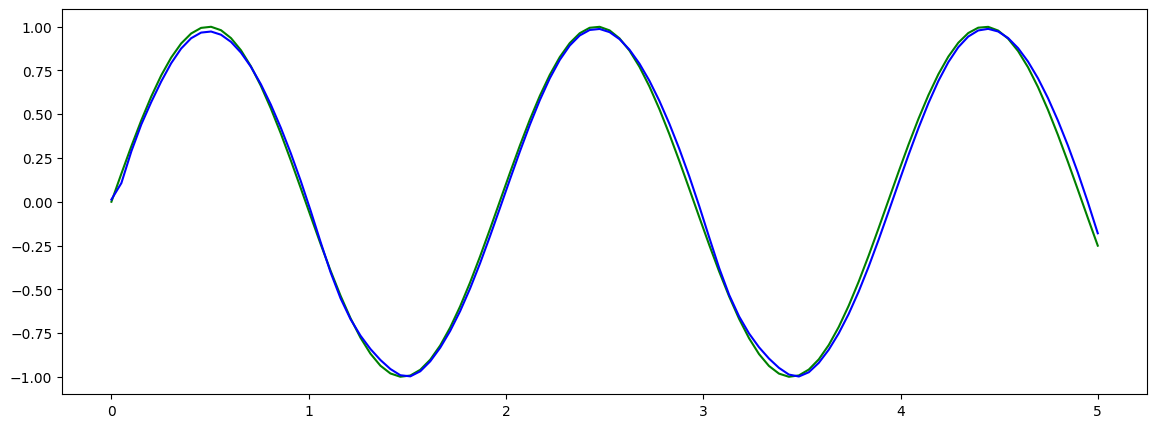

In [38]:
test_inputs, test_targets = gen_data(10,T)
with torch.no_grad():
  test_prediction = sin_three_bodies_rnn(test_inputs,None)[0]
plot_sin(T,test_targets.cpu(),test_prediction.cpu(),loss=None,idx=9)

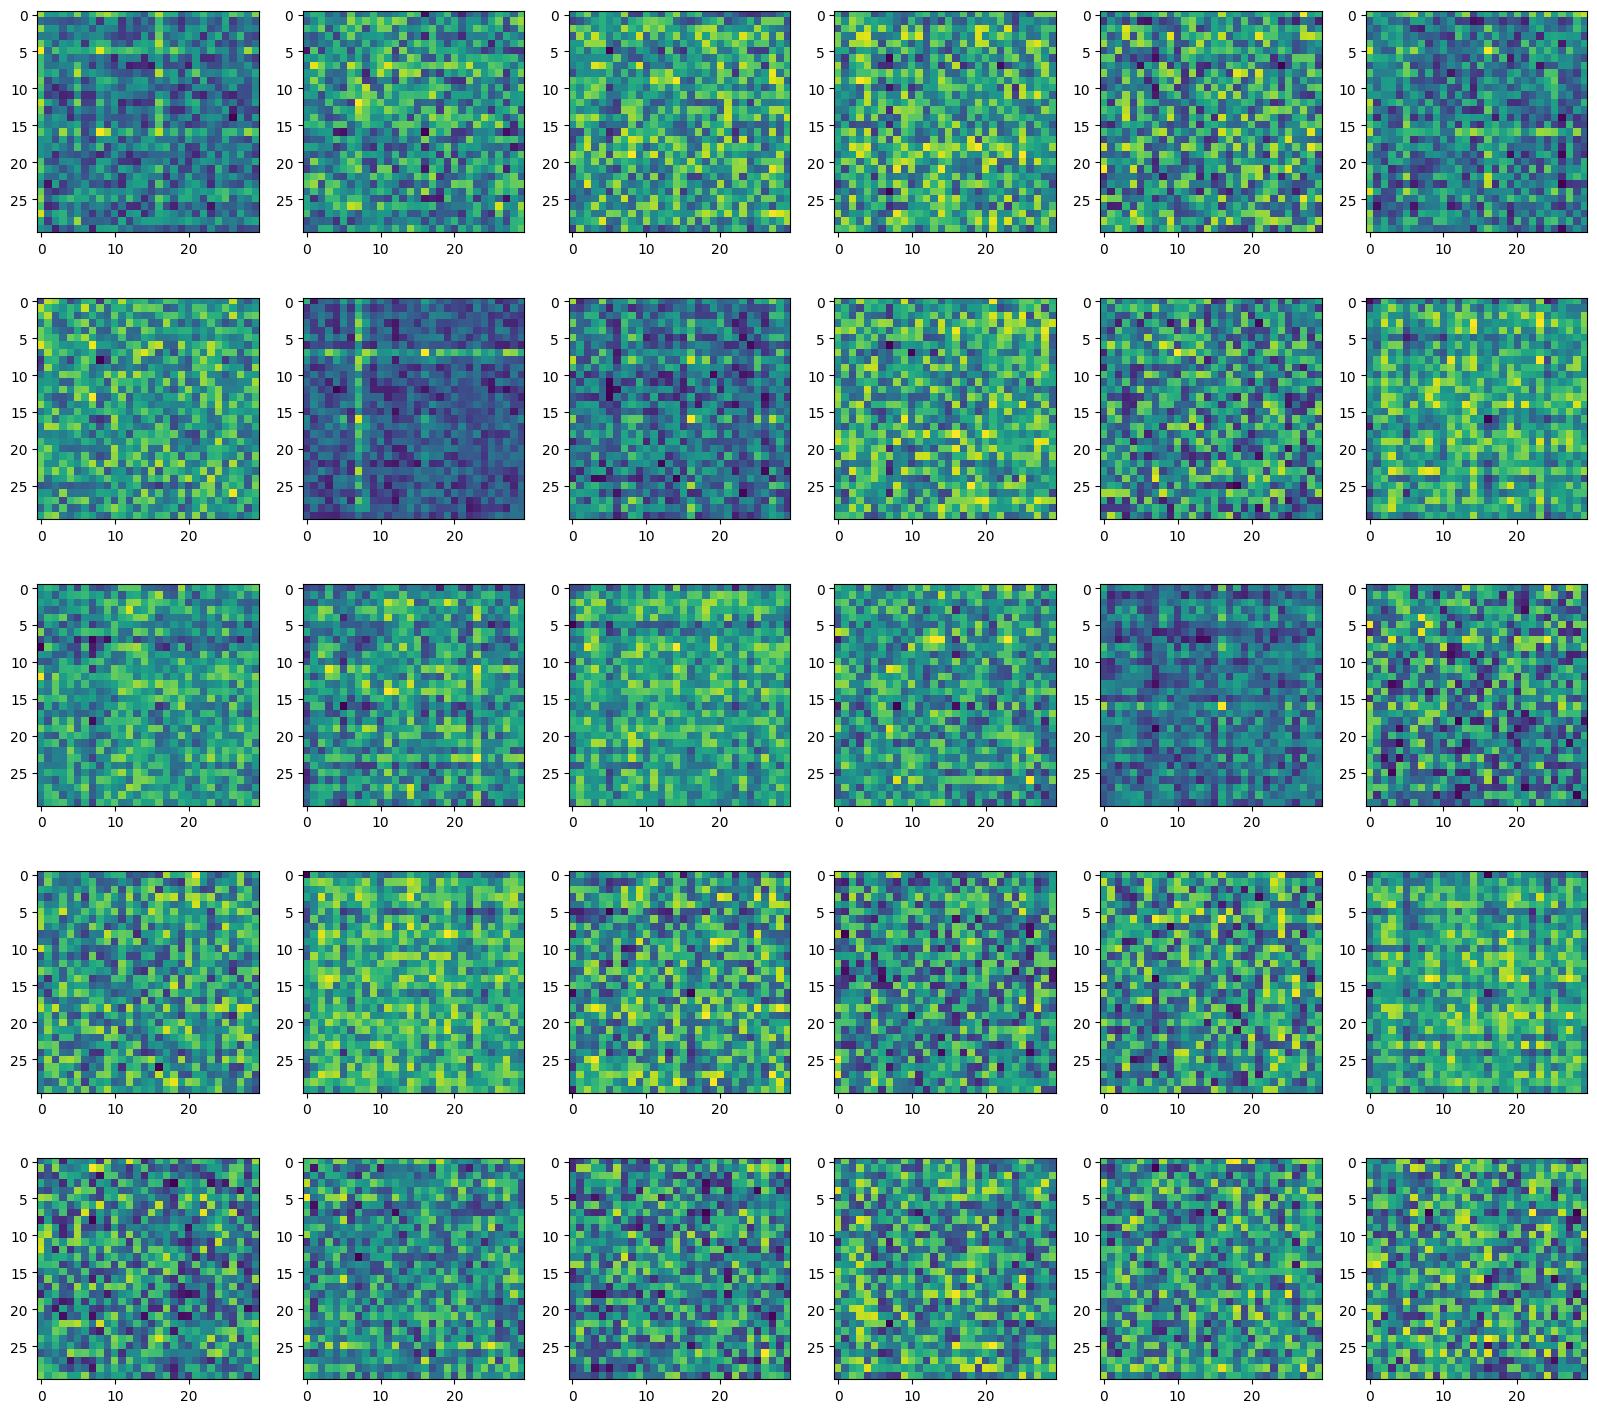

In [39]:
utils.show_connectivity(sin_three_bodies_rnn,hidden_dim)

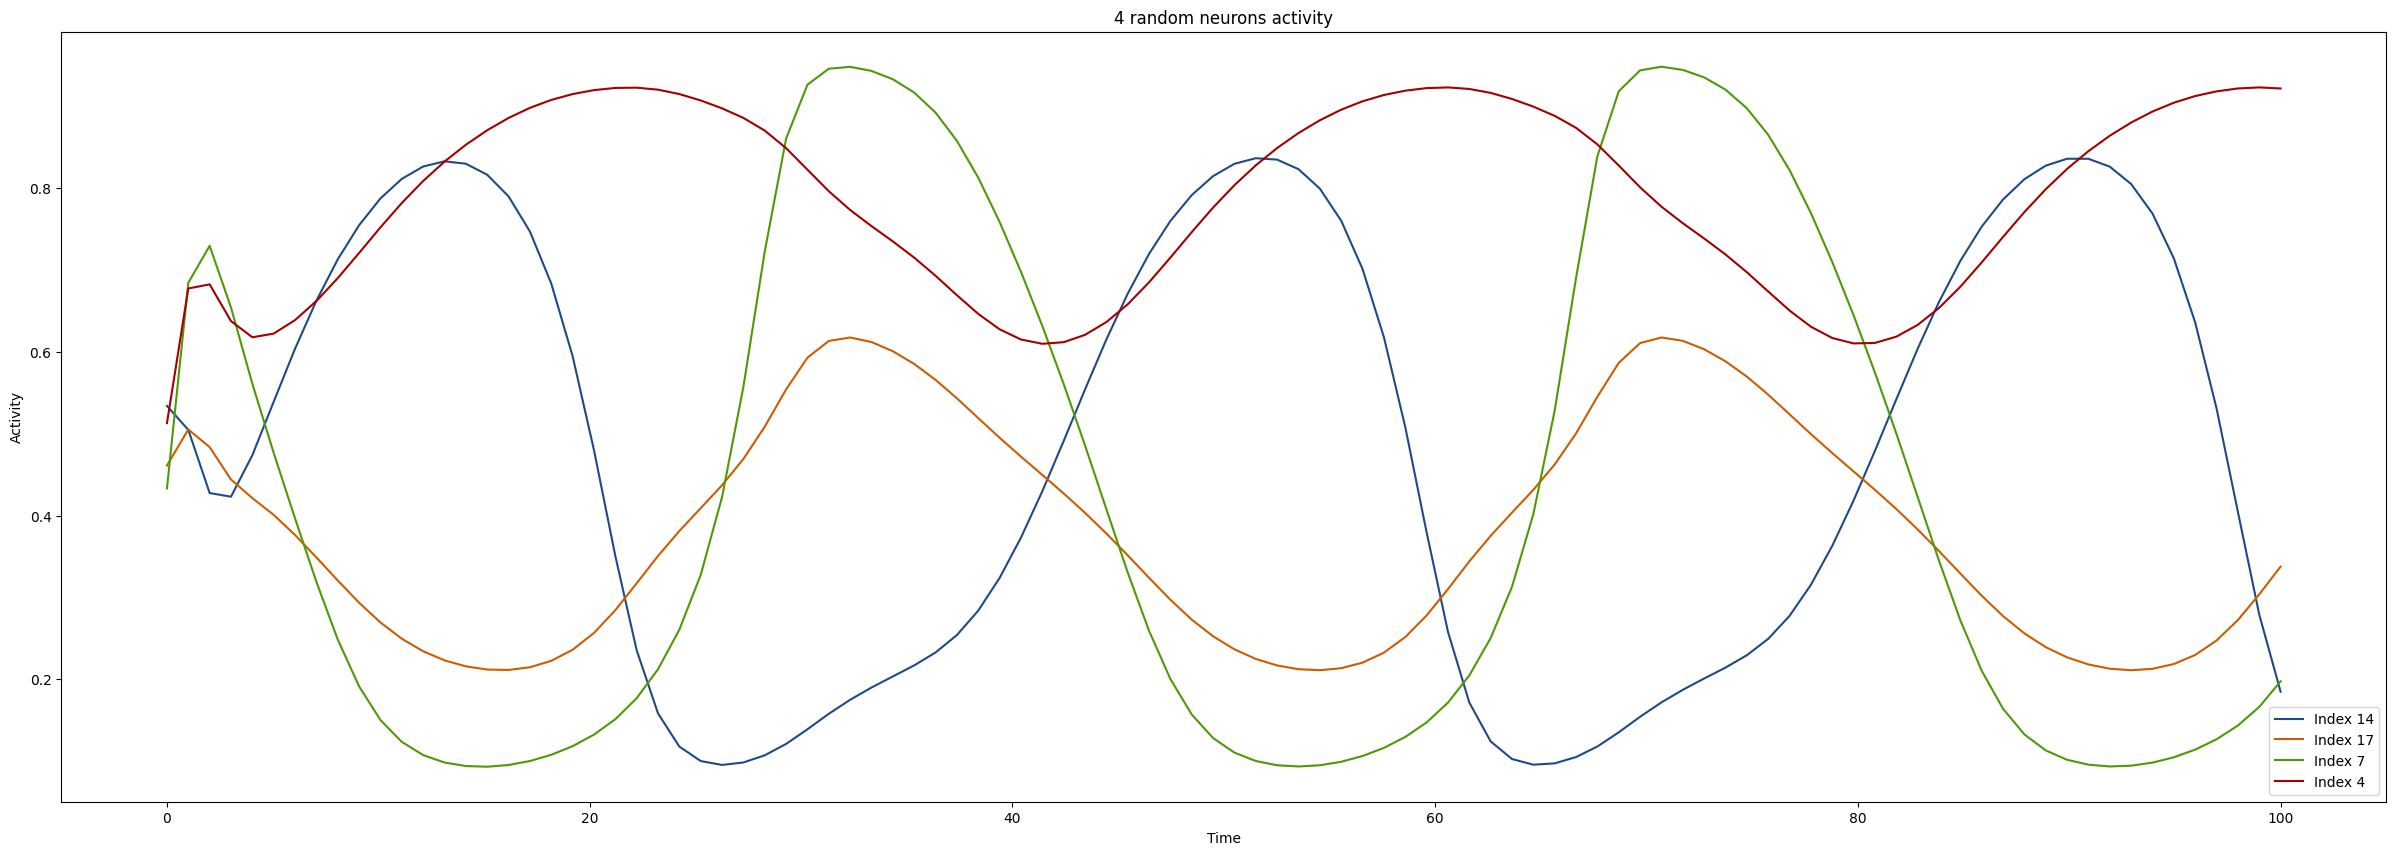

In [41]:
utils.print_rand_neurons(sin_three_bodies_rnn,4,hidden_dim,T,test_inputs)

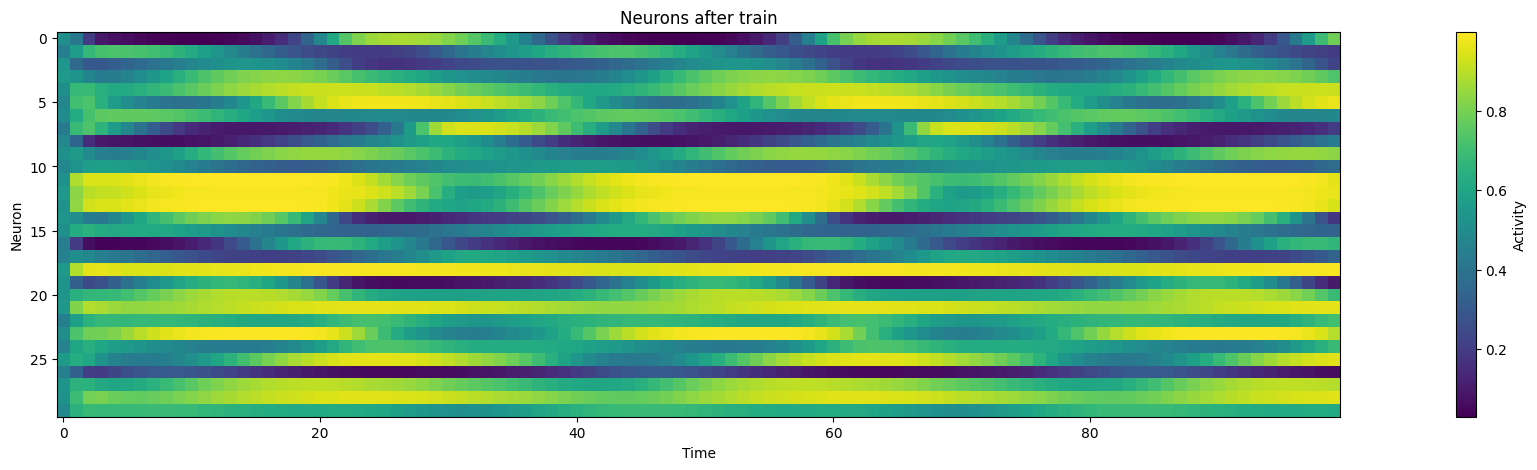

In [42]:
utils.show_neurons(sin_three_bodies_rnn,test_inputs,T)

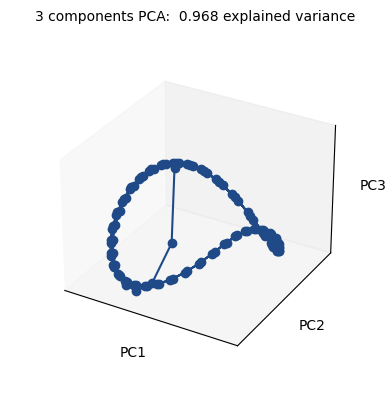

In [53]:
utils.show_pca(sin_three_bodies_rnn,test_inputs,0)

###low rank evaluation

In [108]:
T = 100

# decide on hyperparameters
input_size=1
output_size=1
hidden_dim=30

sin_three_bodies_rnn = Three_Bodies_RNN(input_size, output_size, hidden_dim,torch.sigmoid, task = "Sin").to(DEVICE)
sin_three_bodies_rnn.load_state_dict(torch.load(f"/content/drive/MyDrive/Three_Bodies_Network/models/tb_Sinus.pth"))

# MSE loss and Adam optimizer with a learning rate
criterion = nn.MSELoss().to(DEVICE)

# train parameters
n_steps = 6000
n_batch = 128
batch_size = 128

Inputs, Targets = sin_task.generate_sin_data(n_batch,T)

ranks = 10
r_losses = []

lr = 1e-04

for rank in range(1,ranks+1):
  # instantiate an low rank RNN
  low_rank_rnn = Low_Rank_Three_Way_RNN(input_size, output_size, hidden_dim, rank,nonlinearity = torch.sigmoid, task = "Sin").to(DEVICE)
  optimizer = torch.optim.Adam(low_rank_rnn.parameters(), lr=lr)
  losses = low_rank_rnn.lr_train(Inputs,Targets,sin_three_bodies_rnn,n_steps,optimizer,criterion,batch_size,T)
  r_losses.append(losses)
  torch.save(low_rank_rnn.state_dict(), f'/content/drive/MyDrive/Three_Bodies_Network/Low_Rank_Rnn/Three_Way_Rank_{rank}_RNN_Sinus.pth')

Output hidden; open in https://colab.research.google.com to view.

  0%|          | 0/6000 [00:00<?, ?it/s]

0 /10 --- loss = 0.109508, best = 0.109508
Loss:  0.10950790345668793


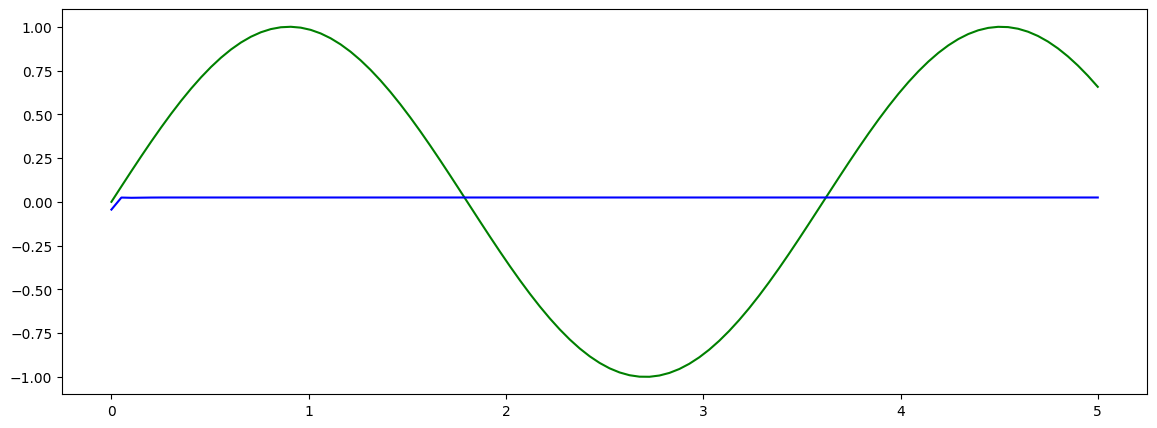

 10%|▉         | 599/6000 [00:43<06:15, 14.39it/s]

1 /10 --- loss = 0.061121, best = 0.061121
Loss:  0.06112121045589447


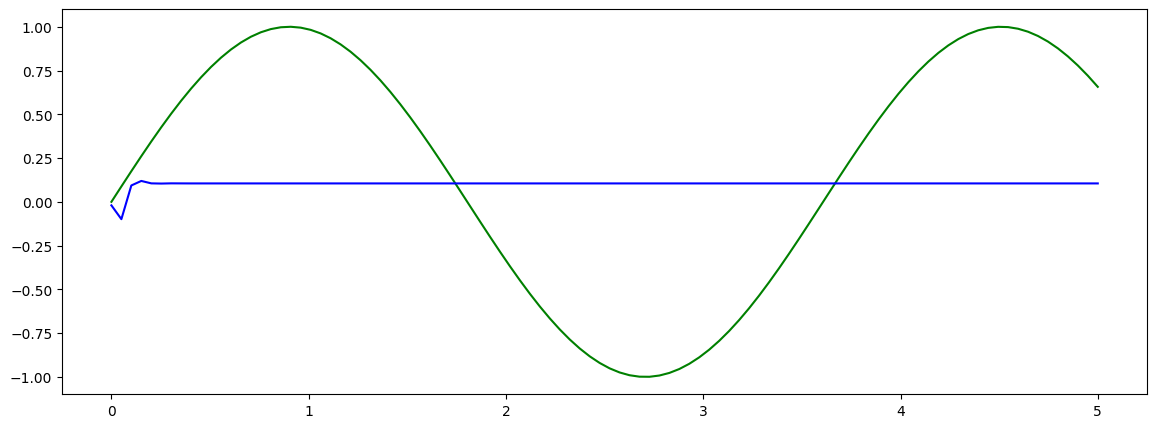

 20%|█▉        | 1199/6000 [01:27<05:49, 13.72it/s]

2 /10 --- loss = 0.050537, best = 0.050537
Loss:  0.05053731054067612


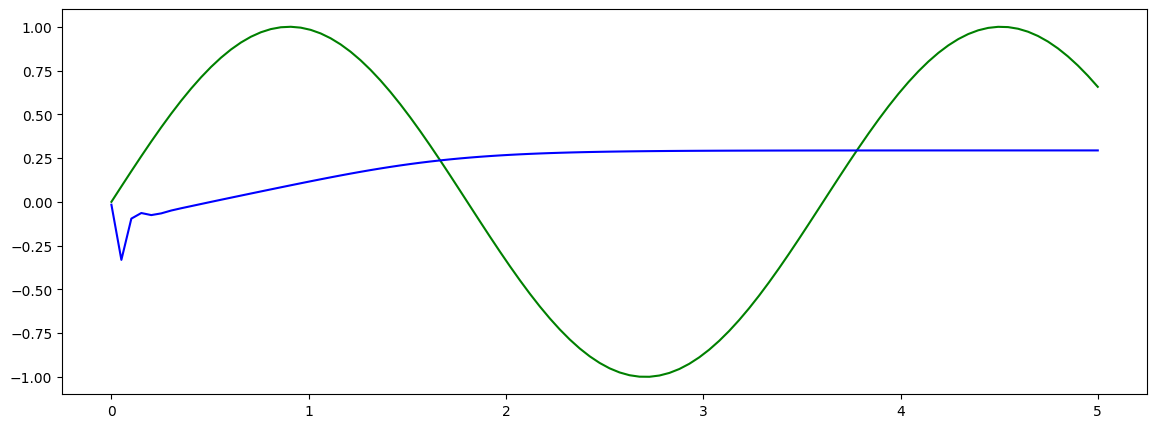

 30%|██▉       | 1799/6000 [02:11<05:01, 13.94it/s]

3 /10 --- loss = 0.033198, best = 0.033198
Loss:  0.03319811075925827


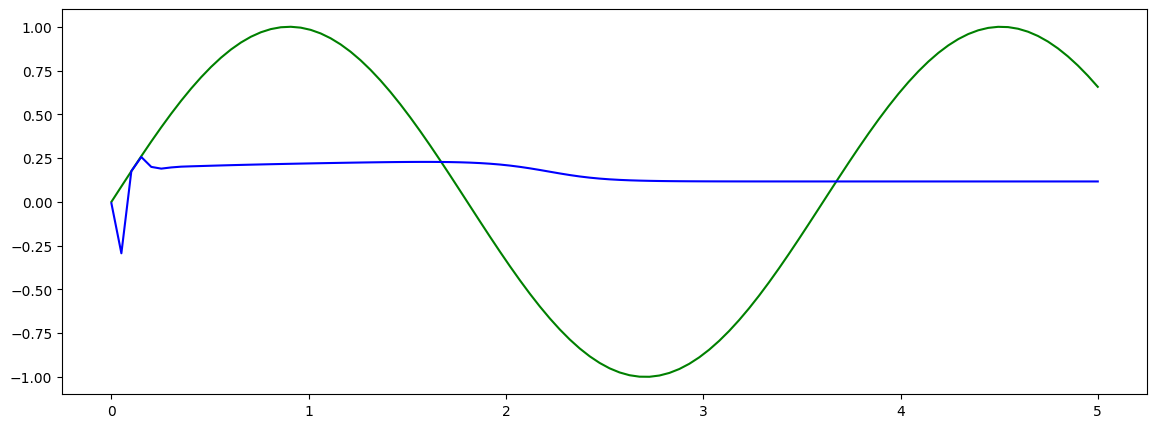

 40%|███▉      | 2399/6000 [02:54<04:12, 14.24it/s]

4 /10 --- loss = 0.028395, best = 0.028395
Loss:  0.028395209461450577


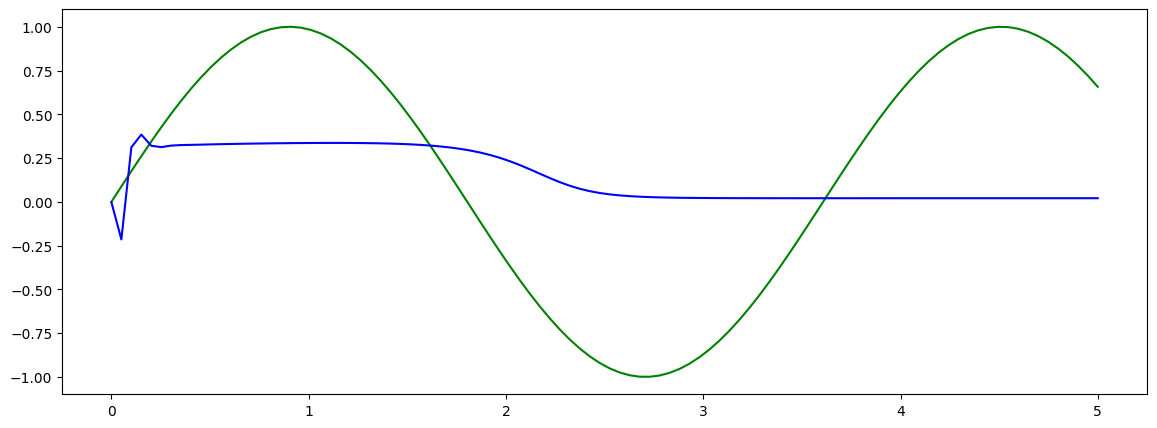

 50%|████▉     | 2999/6000 [03:39<03:40, 13.61it/s]

5 /10 --- loss = 0.024971, best = 0.024971
Loss:  0.02497139759361744


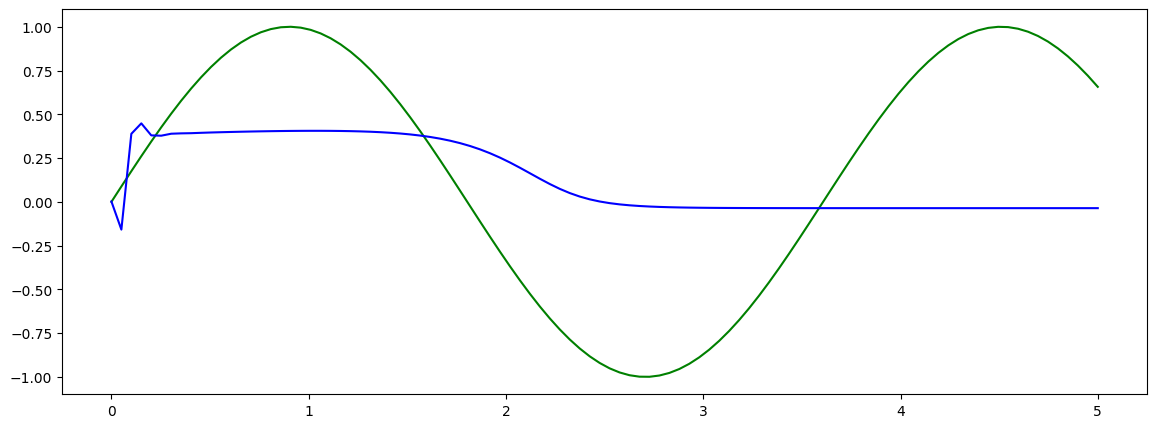

 60%|█████▉    | 3599/6000 [04:23<03:02, 13.15it/s]

6 /10 --- loss = 0.021996, best = 0.021996
Loss:  0.021995915099978447


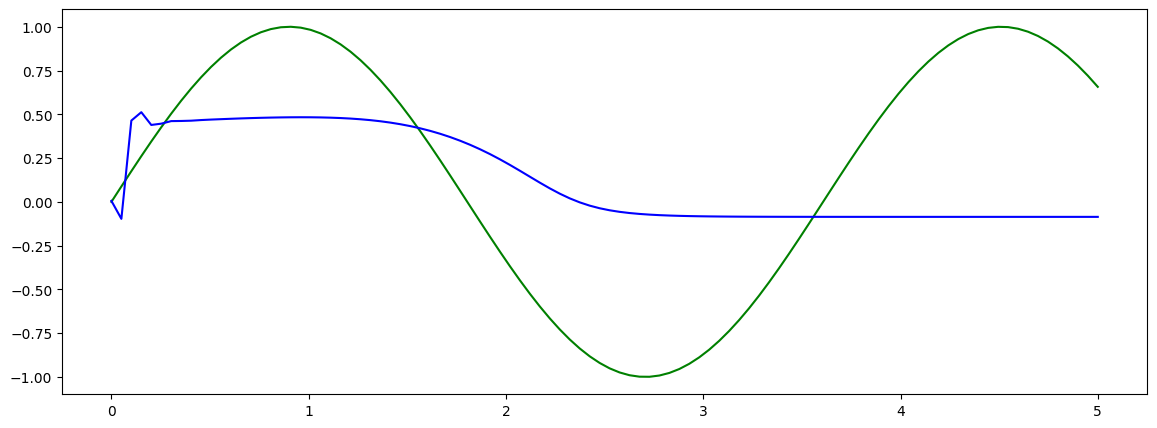

 70%|██████▉   | 4199/6000 [05:07<02:07, 14.17it/s]

7 /10 --- loss = 0.019377, best = 0.019377
Loss:  0.019376827403903008


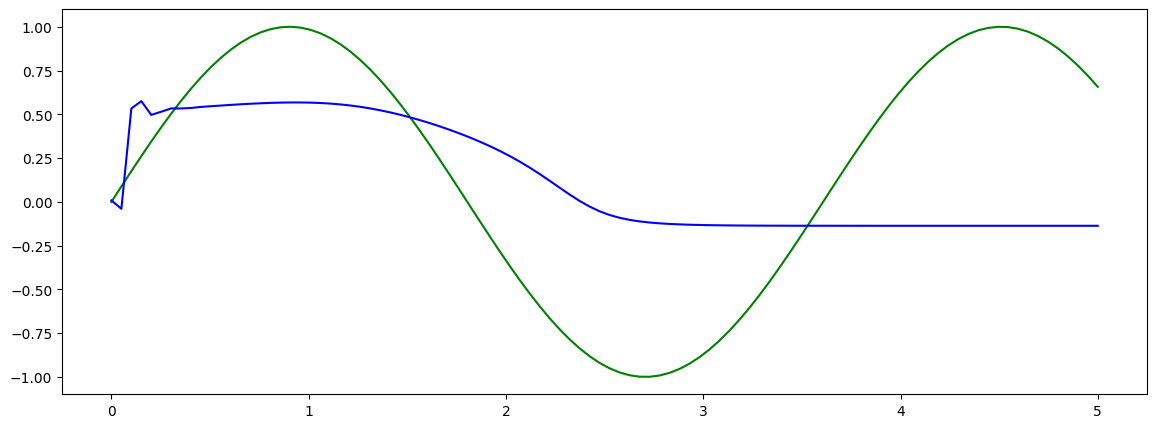

 80%|███████▉  | 4799/6000 [05:51<01:29, 13.48it/s]

8 /10 --- loss = 0.017820, best = 0.017805
Loss:  0.017820170149207115


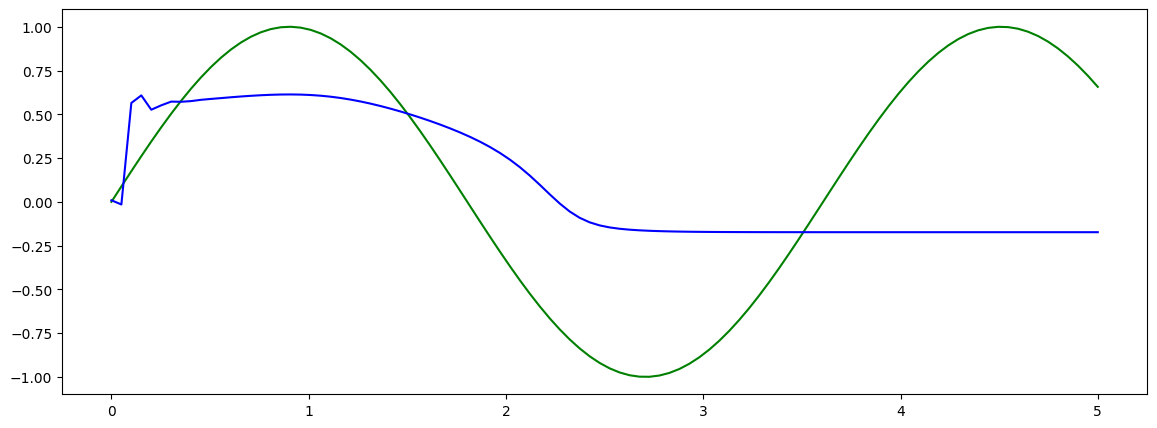

 90%|████████▉ | 5399/6000 [06:36<00:45, 13.08it/s]

9 /10 --- loss = 0.016944, best = 0.016944
Loss:  0.01694384030997753


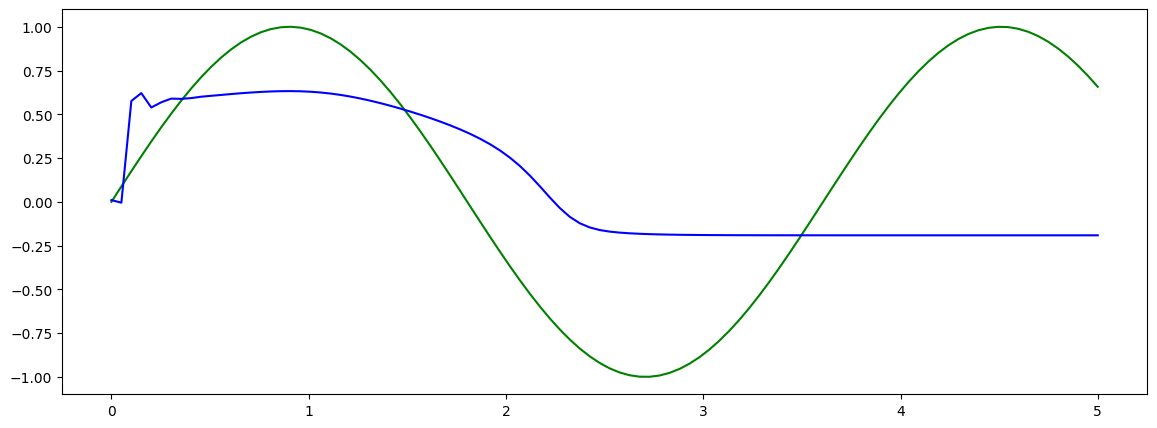

100%|██████████| 6000/6000 [07:19<00:00, 13.65it/s]

Loss:  0.01640365645289421


In [111]:
rank=15
low_rank_rnn = Low_Rank_Three_Way_RNN(input_size, output_size, hidden_dim, rank,nonlinearity = torch.sigmoid, task = "Sin").to(DEVICE)
optimizer = torch.optim.Adam(low_rank_rnn.parameters(), lr=lr)
losses = low_rank_rnn.lr_train(Inputs,Targets,sin_three_bodies_rnn,n_steps,optimizer,criterion,batch_size,T)
r_losses.append(losses)
torch.save(low_rank_rnn.state_dict(), f'/content/drive/MyDrive/Three_Bodies_Network/Low_Rank_Rnn/Three_Way_Rank_{rank}_RNN_Sinus.pth')

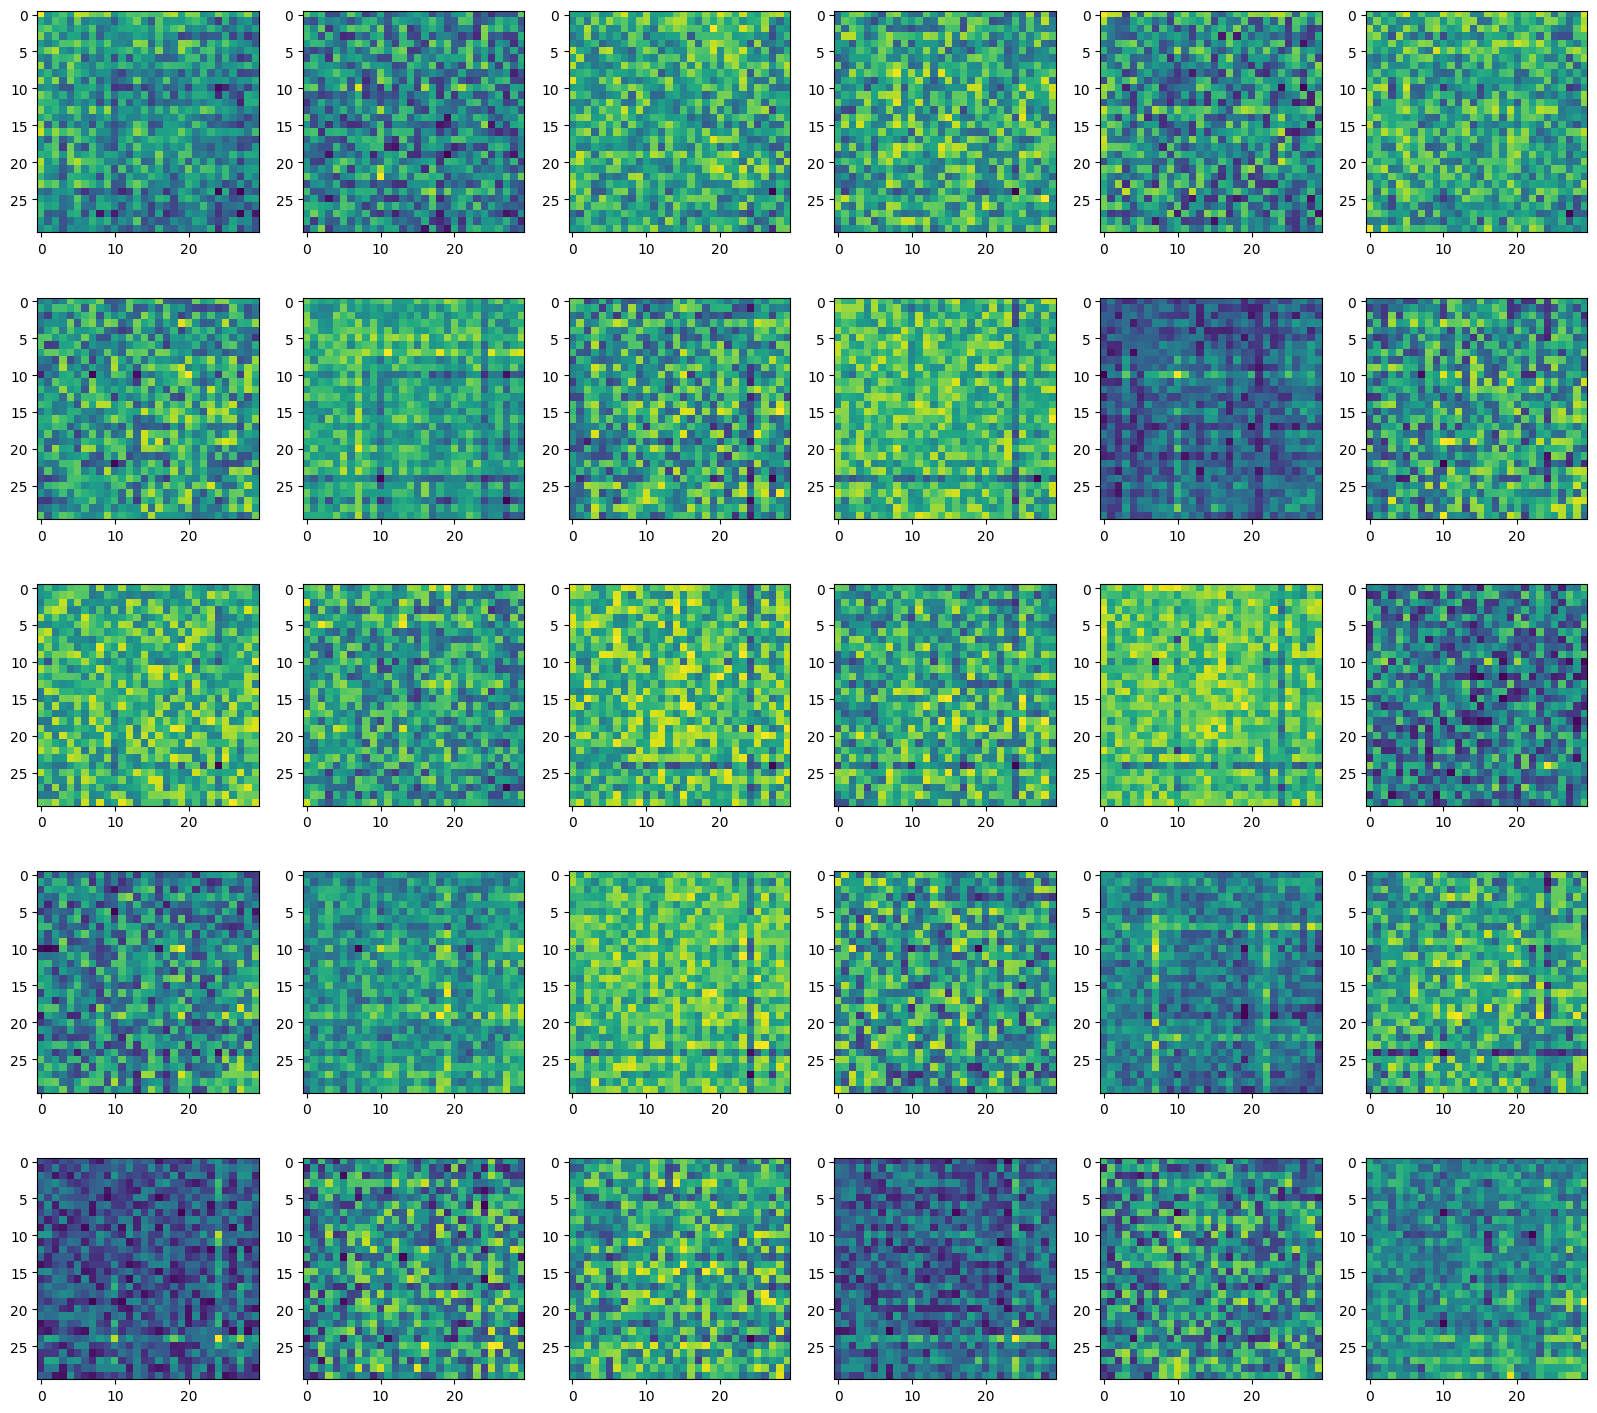

In [109]:
utils.show_connectivity(sin_three_bodies_rnn,30)

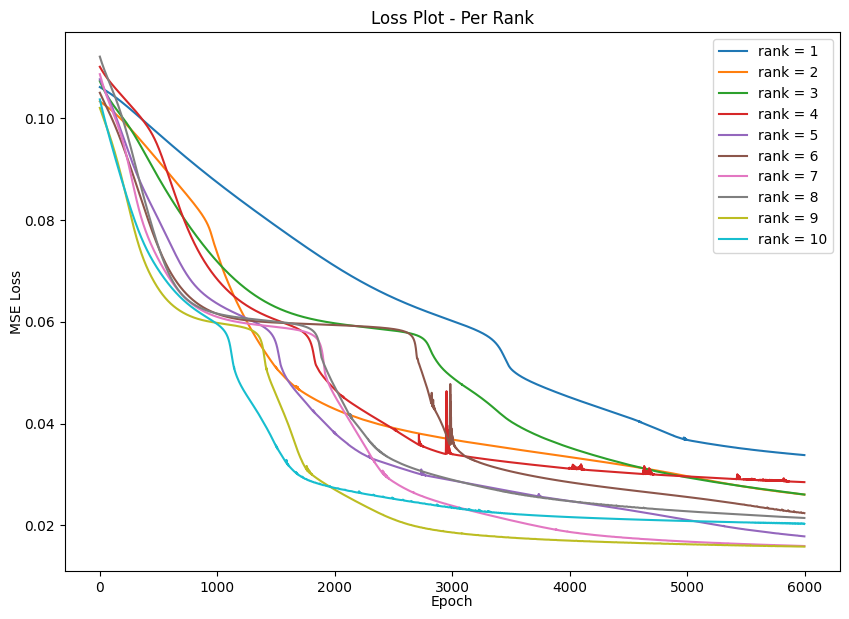

In [115]:
fig = plt.figure(figsize=(10,7))
ax = fig.add_subplot(1,1,1)
for rank in range(ranks):
  _=ax.plot(r_losses[rank],label = f'rank = {rank+1}')
_=ax.set_title("Loss Plot - Per Rank")
_=ax.set_xlabel("Epoch")
_=ax.set_ylabel("MSE Loss")
_=ax.legend()

  0%|          | 0/6000 [00:00<?, ?it/s]

0 /10 --- loss = 0.148161, best = 0.148161
Loss:  0.14816099405288696


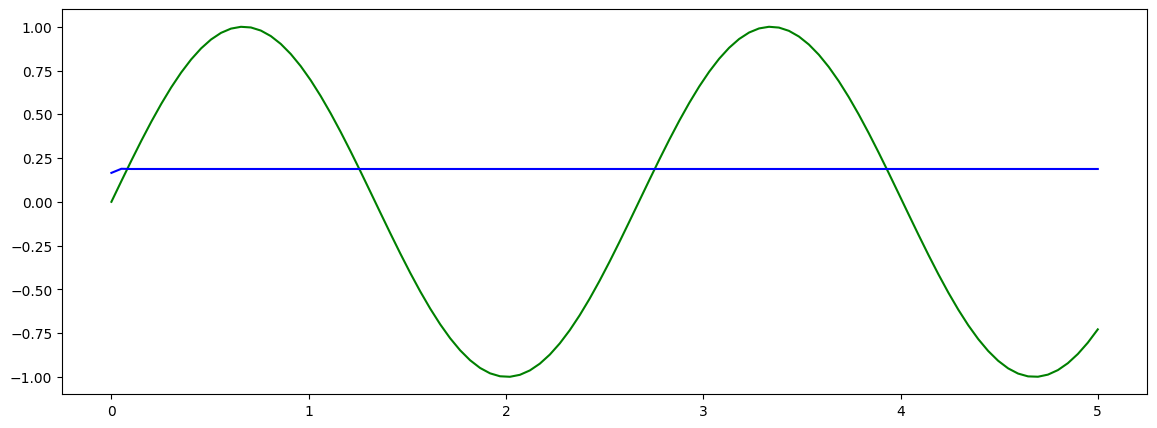

 10%|▉         | 599/6000 [00:35<05:19, 16.90it/s]

1 /10 --- loss = 0.125496, best = 0.125496
Loss:  0.1254955381155014


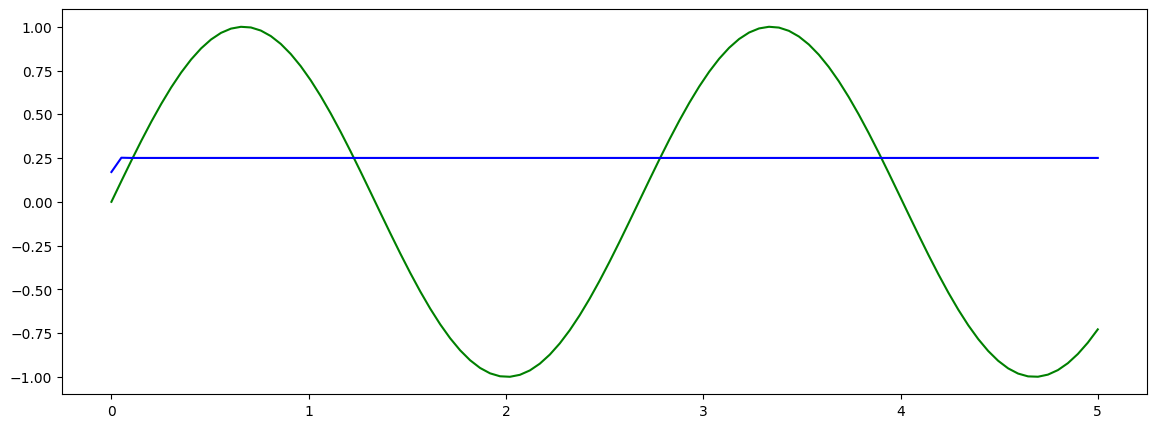

 20%|█▉        | 1199/6000 [01:10<04:40, 17.11it/s]

2 /10 --- loss = 0.101566, best = 0.101566
Loss:  0.10156556218862534


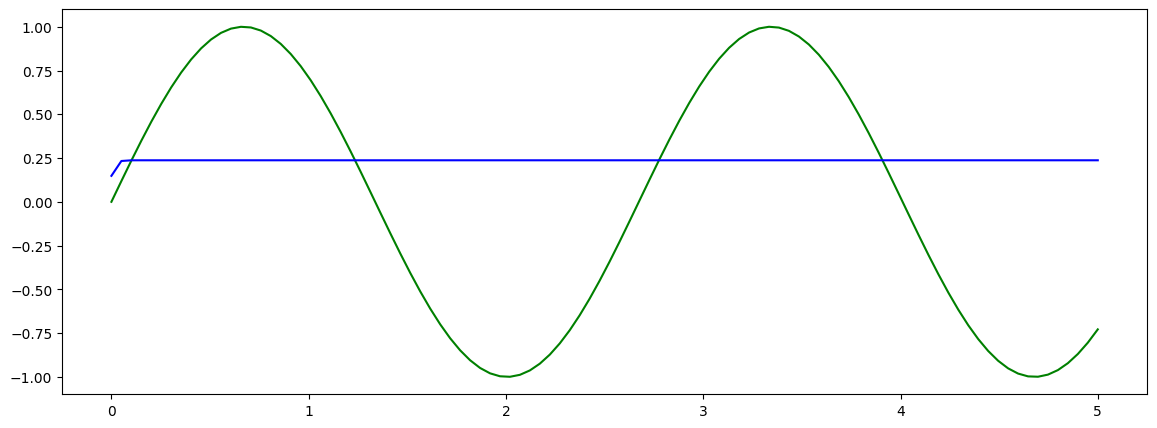

 30%|██▉       | 1799/6000 [01:47<04:41, 14.91it/s]

3 /10 --- loss = 0.085374, best = 0.085374
Loss:  0.08537446707487106


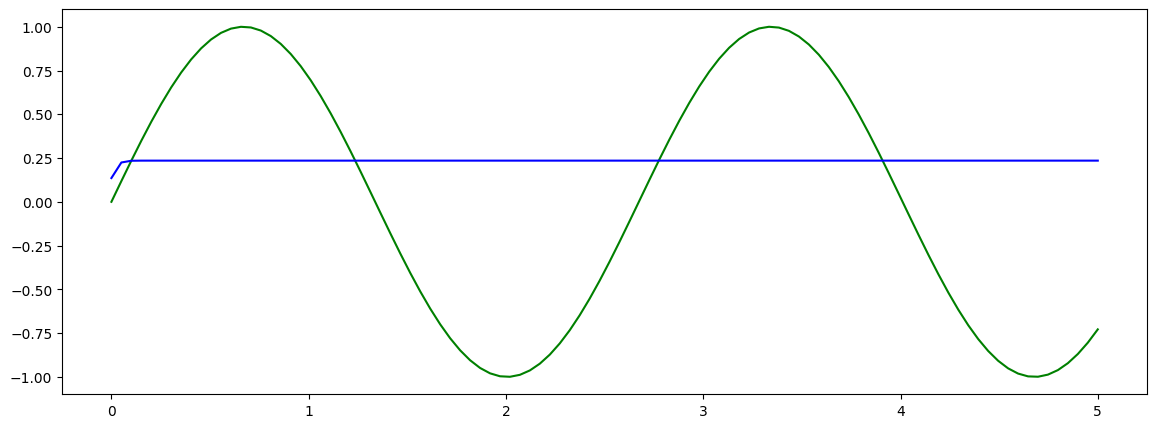

 40%|███▉      | 2399/6000 [02:23<03:30, 17.11it/s]

4 /10 --- loss = 0.074773, best = 0.074773
Loss:  0.07477300614118576


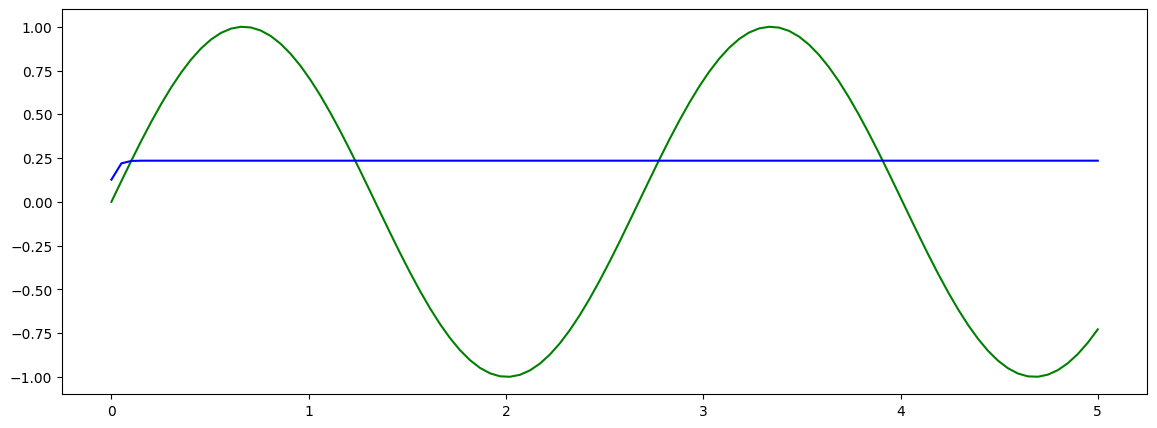

 50%|████▉     | 2999/6000 [02:58<03:06, 16.05it/s]

5 /10 --- loss = 0.067676, best = 0.067676
Loss:  0.06767597794532776


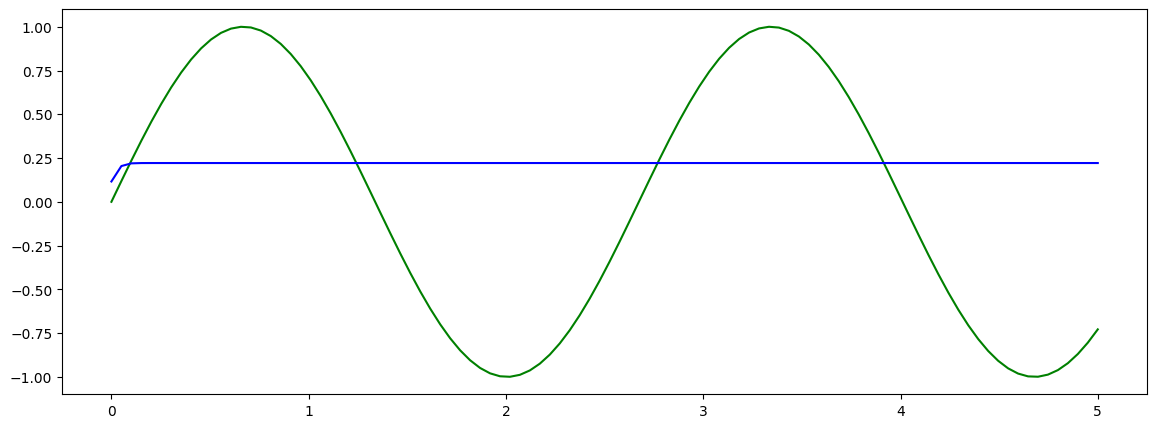

 60%|█████▉    | 3599/6000 [03:33<02:34, 15.59it/s]

6 /10 --- loss = 0.063080, best = 0.063080
Loss:  0.06308027356863022


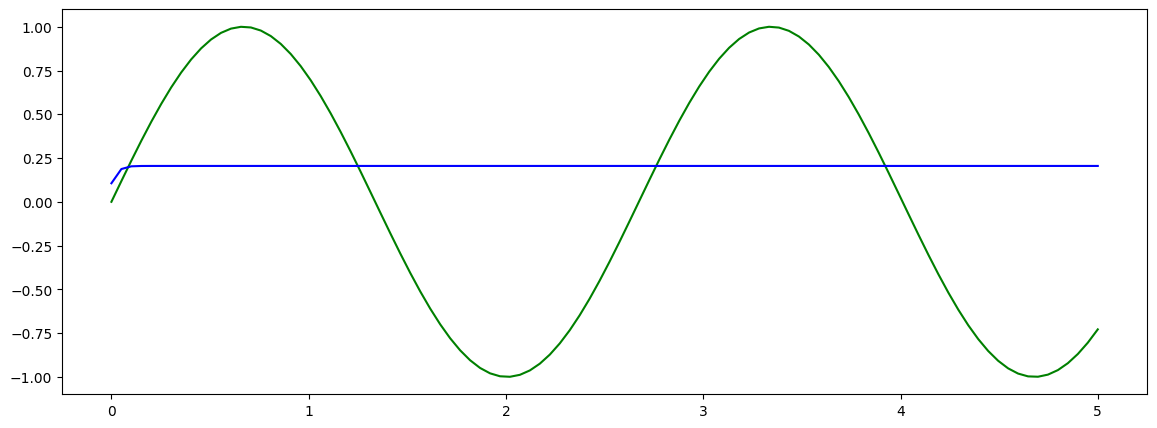

 70%|██████▉   | 4199/6000 [04:09<01:45, 17.03it/s]

7 /10 --- loss = 0.060310, best = 0.060310
Loss:  0.06031031161546707


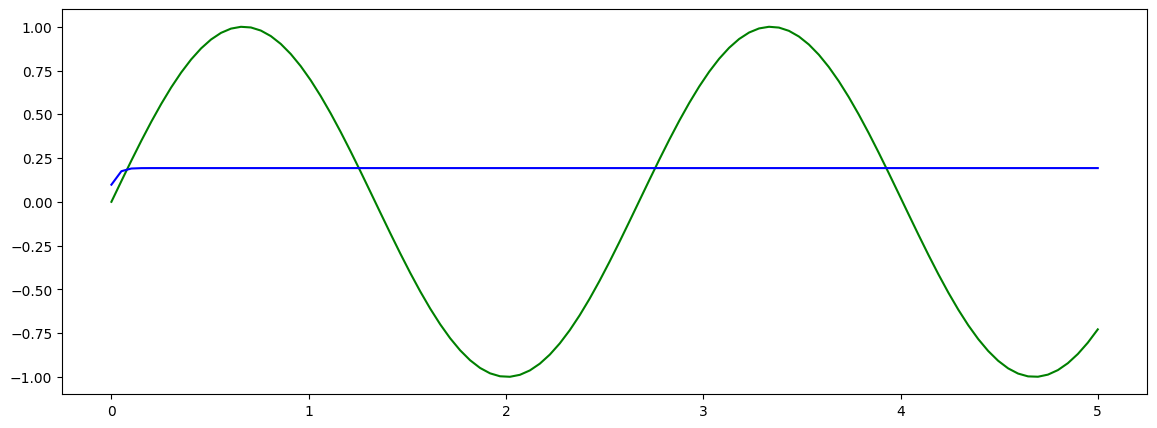

 80%|███████▉  | 4786/6000 [04:44<01:12, 16.83it/s]


KeyboardInterrupt: ignored

In [116]:
T = 100

# decide on hyperparameters
input_size=1
output_size=1
hidden_dim=30

sin_three_bodies_rnn = Three_Bodies_RNN(input_size, output_size, hidden_dim,torch.sigmoid, task = "Sin").to(DEVICE)
sin_three_bodies_rnn.load_state_dict(torch.load(f"/content/drive/MyDrive/Three_Bodies_Network/models/tb_Sinus.pth"))

# MSE loss and Adam optimizer with a learning rate
criterion = nn.MSELoss().to(DEVICE)

# train parameters
n_steps = 6000
n_batch = 128
batch_size = 128

Inputs, Targets = sin_task.generate_sin_data(n_batch,T)

ranks = 10
r_losses = []

lr = 1e-04

for rank in range(1,ranks+1):
  # instantiate an low rank RNN
  low_rank_rnn = Low_Rank_RNN(input_size, output_size, hidden_dim, rank,nonlinearity = torch.sigmoid, task = "Sin").to(DEVICE)
  optimizer = torch.optim.Adam(low_rank_rnn.parameters(), lr=lr)
  losses = low_rank_rnn.lr_train(Inputs,Targets,sin_three_bodies_rnn,n_steps,optimizer,criterion,batch_size,T)
  r_losses.append(losses)
  torch.save(low_rank_rnn.state_dict(), f'/content/drive/MyDrive/Three_Bodies_Network/Low_Rank_Rnn/Low_Rank_{rank}_RNN_Sinus.pth')

  0%|          | 0/10000 [00:00<?, ?it/s]

0 /10 --- loss = 0.144055, best = 0.144055
Loss:  0.14405511319637299


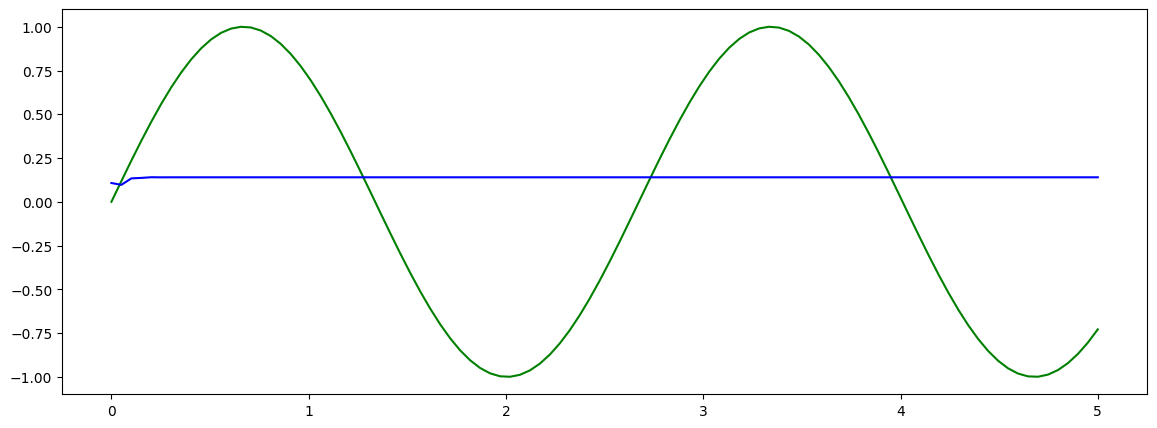

 10%|▉         | 999/10000 [01:00<09:00, 16.64it/s]

1 /10 --- loss = 0.061083, best = 0.061083
Loss:  0.06108328327536583


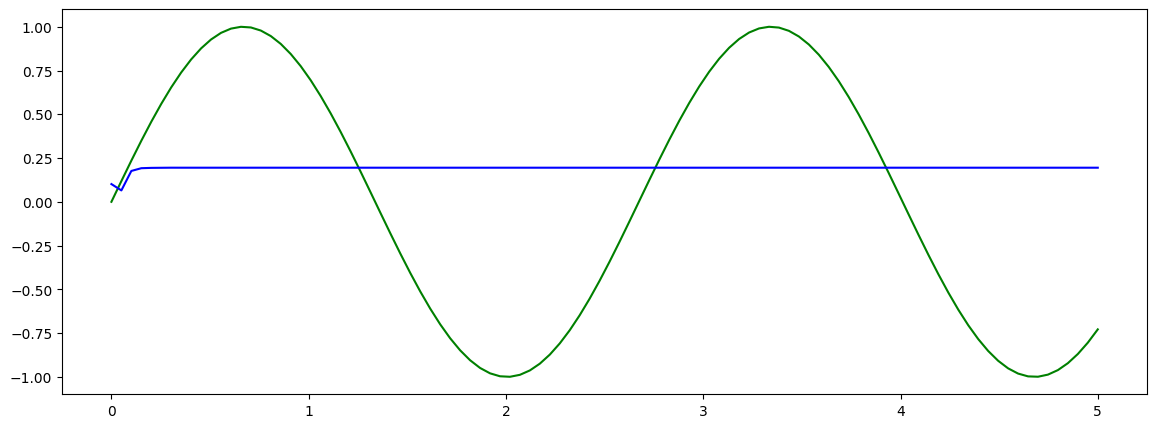

 20%|█▉        | 1999/10000 [02:02<07:45, 17.19it/s]

2 /10 --- loss = 0.026255, best = 0.026255
Loss:  0.02625528909265995


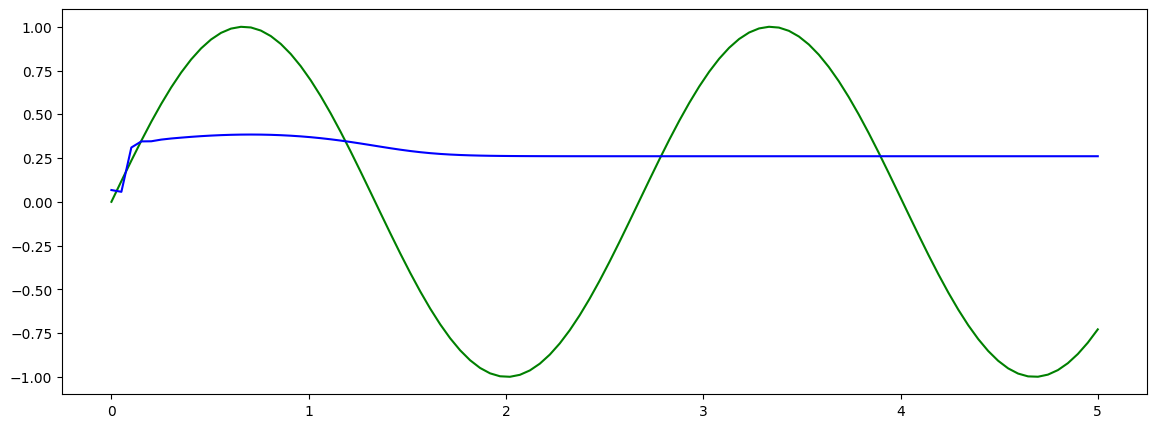

 30%|██▉       | 2999/10000 [03:03<07:04, 16.50it/s]

3 /10 --- loss = 0.019689, best = 0.019689
Loss:  0.019688500091433525


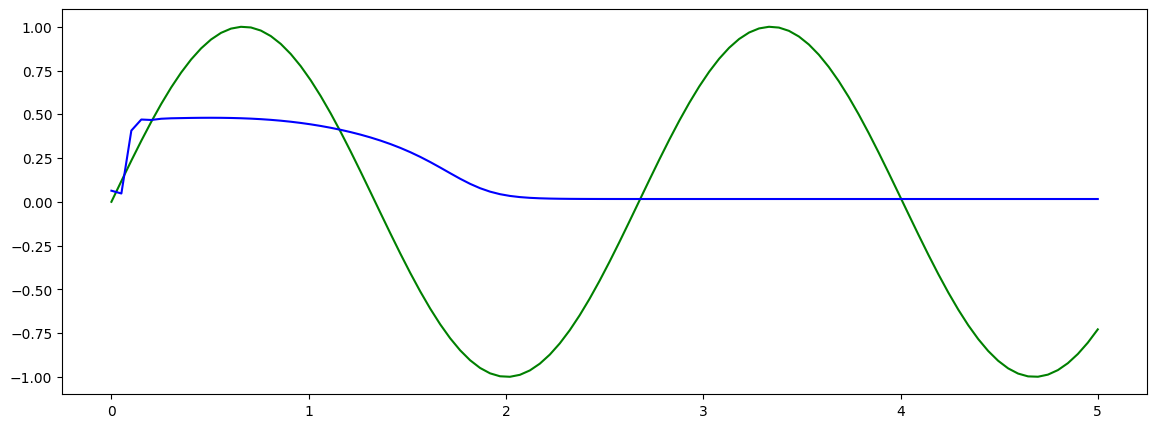

 40%|███▉      | 3999/10000 [04:03<05:55, 16.87it/s]

4 /10 --- loss = 0.017880, best = 0.017880
Loss:  0.01787981204688549


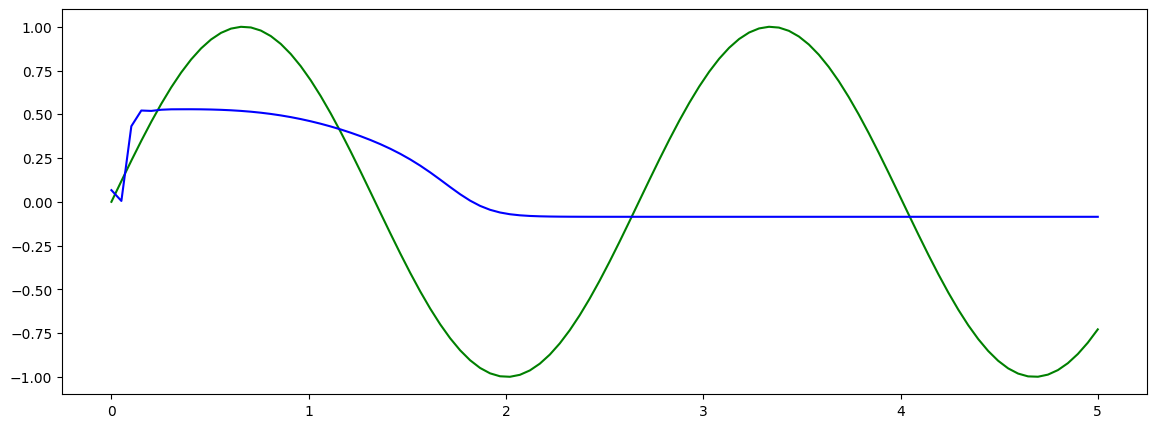

 50%|████▉     | 4999/10000 [05:03<04:57, 16.81it/s]

5 /10 --- loss = 0.016896, best = 0.016896
Loss:  0.016896480694413185


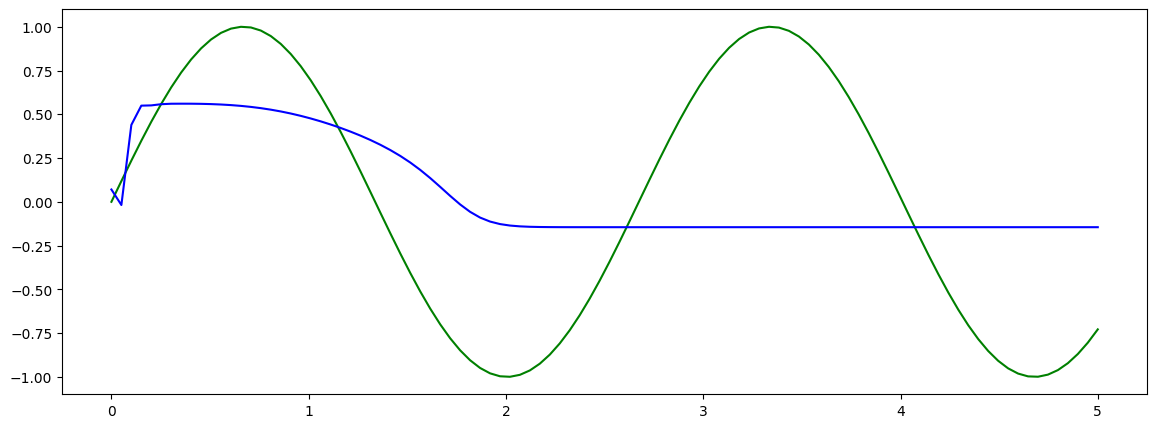

 60%|█████▉    | 5999/10000 [06:03<03:52, 17.24it/s]

6 /10 --- loss = 0.016273, best = 0.016272
Loss:  0.016273194923996925


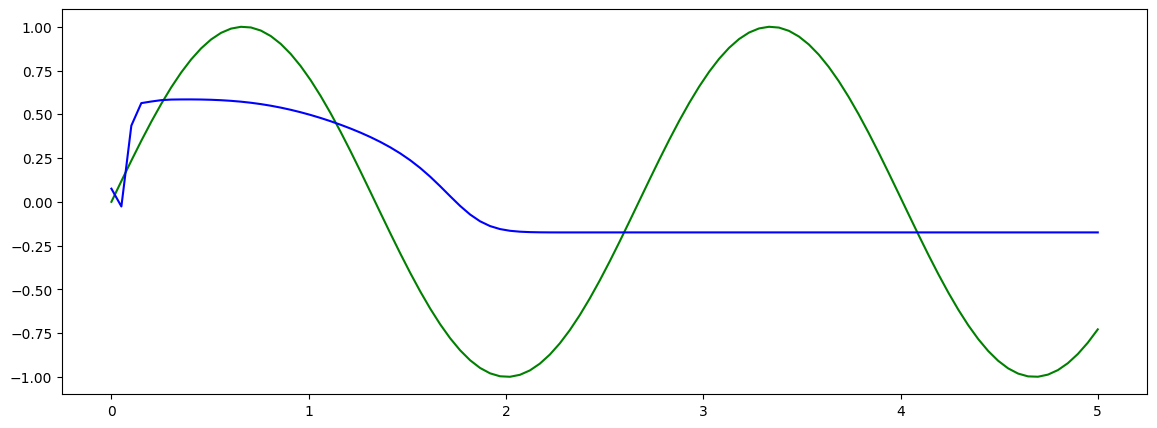

 70%|██████▉   | 6999/10000 [07:04<03:08, 15.91it/s]

7 /10 --- loss = 0.015770, best = 0.015770
Loss:  0.015770485624670982


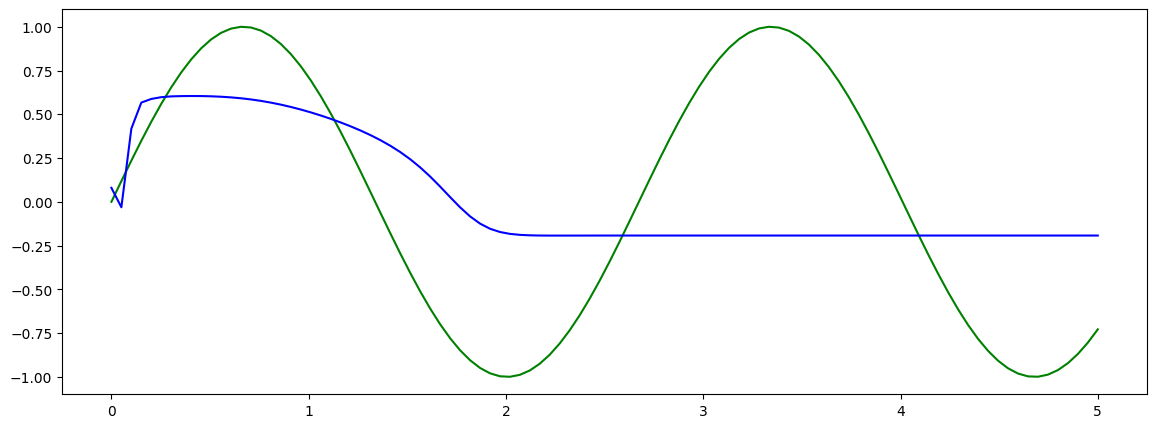

 80%|███████▉  | 7999/10000 [08:05<01:59, 16.69it/s]

8 /10 --- loss = 0.015339, best = 0.015339
Loss:  0.015338883735239506


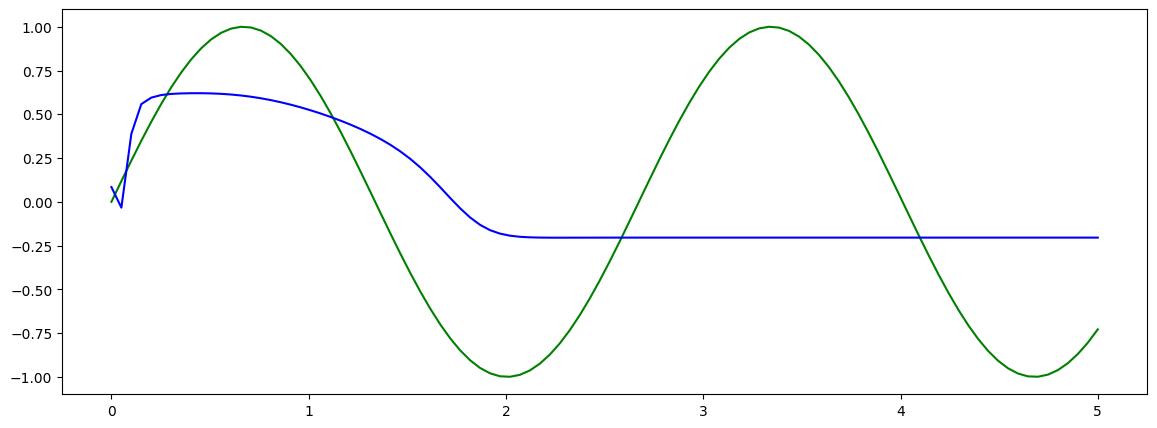

 90%|████████▉ | 8999/10000 [09:05<01:00, 16.58it/s]

9 /10 --- loss = 0.014955, best = 0.014953
Loss:  0.01495504379272461


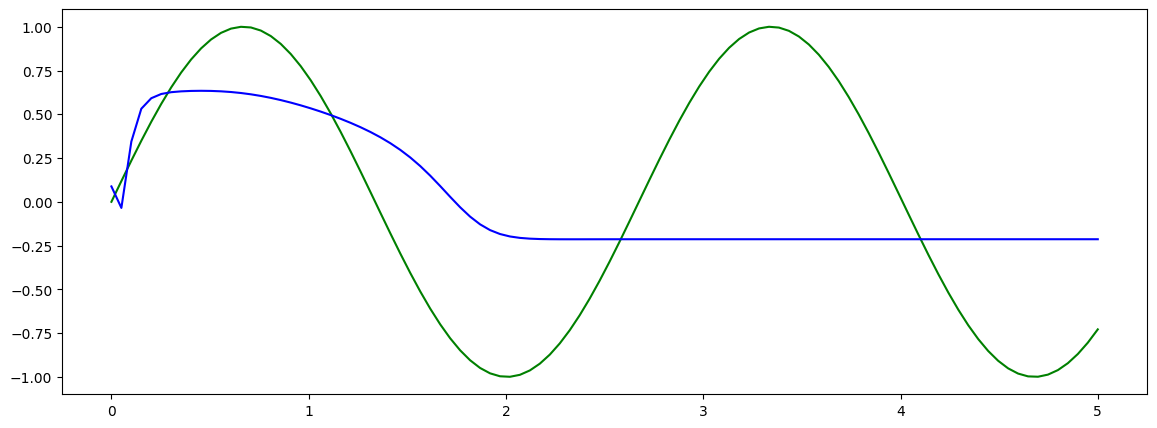

100%|██████████| 10000/10000 [10:08<00:00, 16.44it/s]


Loss:  0.01454521156847477


In [123]:
rank=30
low_rank_rnn = Low_Rank_RNN(input_size, output_size, hidden_dim, rank,nonlinearity = torch.sigmoid, task = "Sin").to(DEVICE)
optimizer = torch.optim.Adam(low_rank_rnn.parameters(), lr=lr)
losses = low_rank_rnn.lr_train(Inputs,Targets,sin_three_bodies_rnn,10000,optimizer,criterion,batch_size,T)
r_losses.append(losses)
torch.save(low_rank_rnn.state_dict(), f'/content/drive/MyDrive/Three_Bodies_Network/Low_Rank_Rnn/Low_Rank_{rank}_RNN_Sinus.pth')

##K Bit Flip Flop task

### Experiment with tanh

<ipython-input-14-feba2fe119f0>:4: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  t_in = torch.tensor(t_in,dtype=torch.float32)
  0%|          | 0/3000 [00:00<?, ?it/s]

0 /10 --- loss = 0.993166


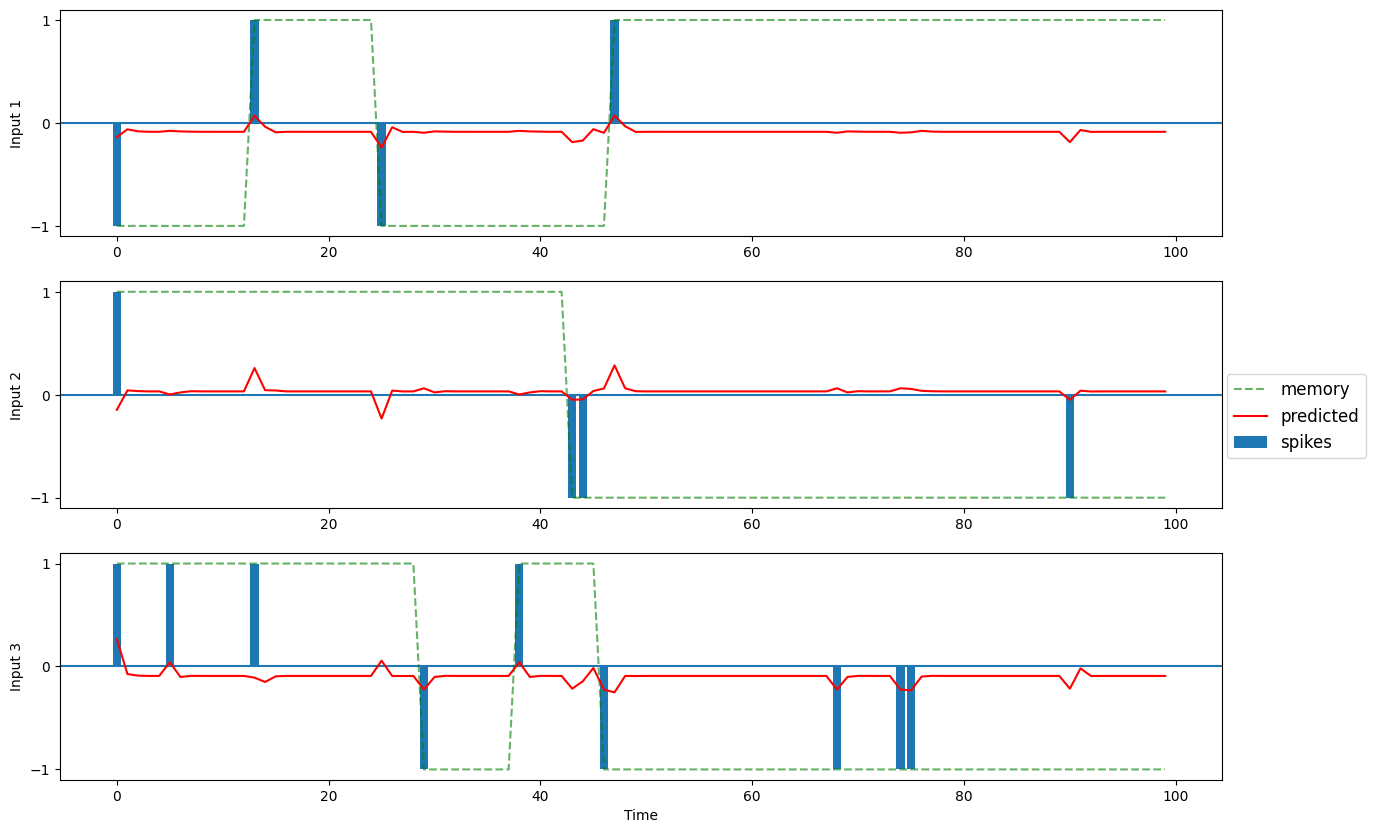

 10%|█         | 300/3000 [03:40<33:43,  1.33it/s]

1 /10 --- loss = 0.620774


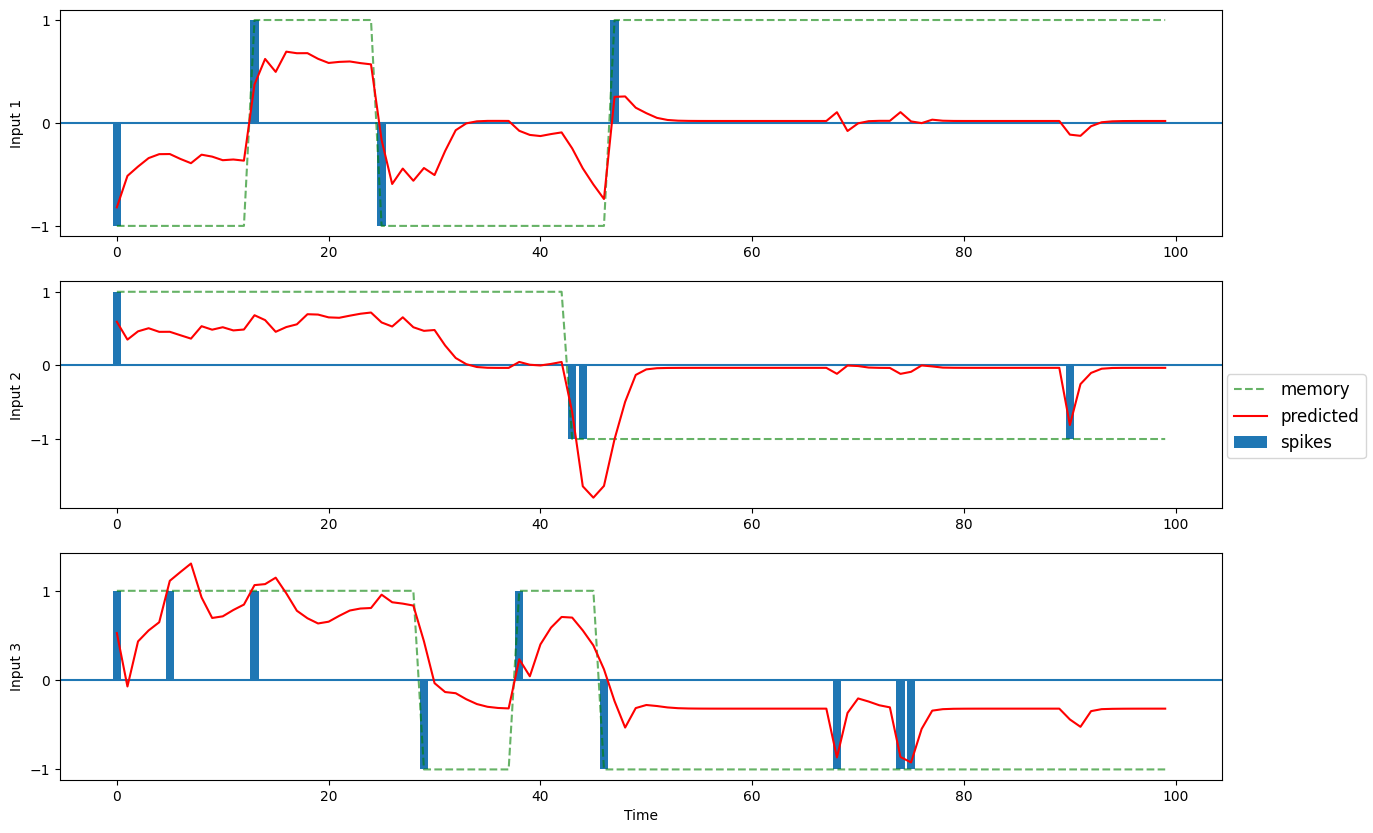

 20%|██        | 600/3000 [07:20<28:57,  1.38it/s]

2 /10 --- loss = 0.134335


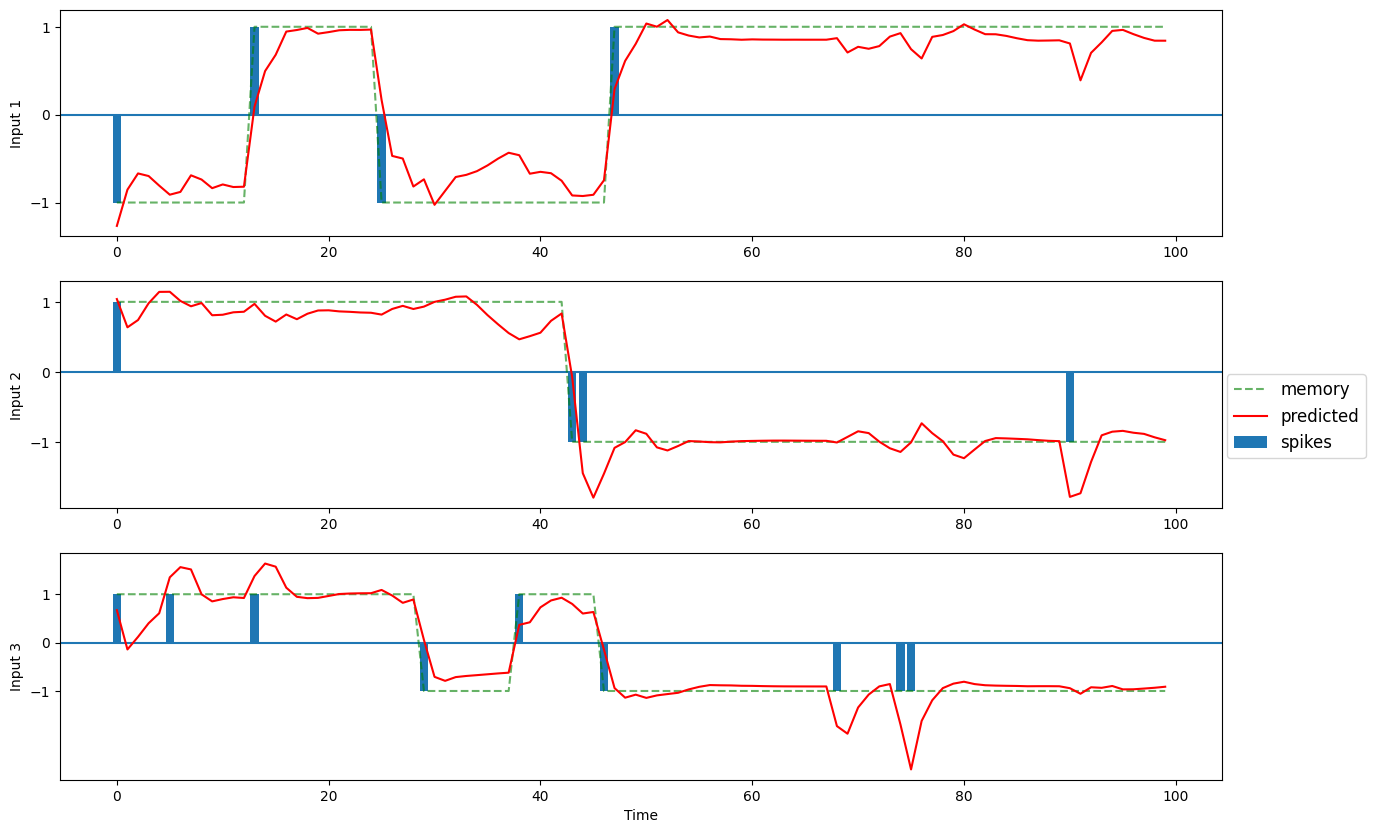

 30%|███       | 900/3000 [11:01<24:52,  1.41it/s]

3 /10 --- loss = 0.061447


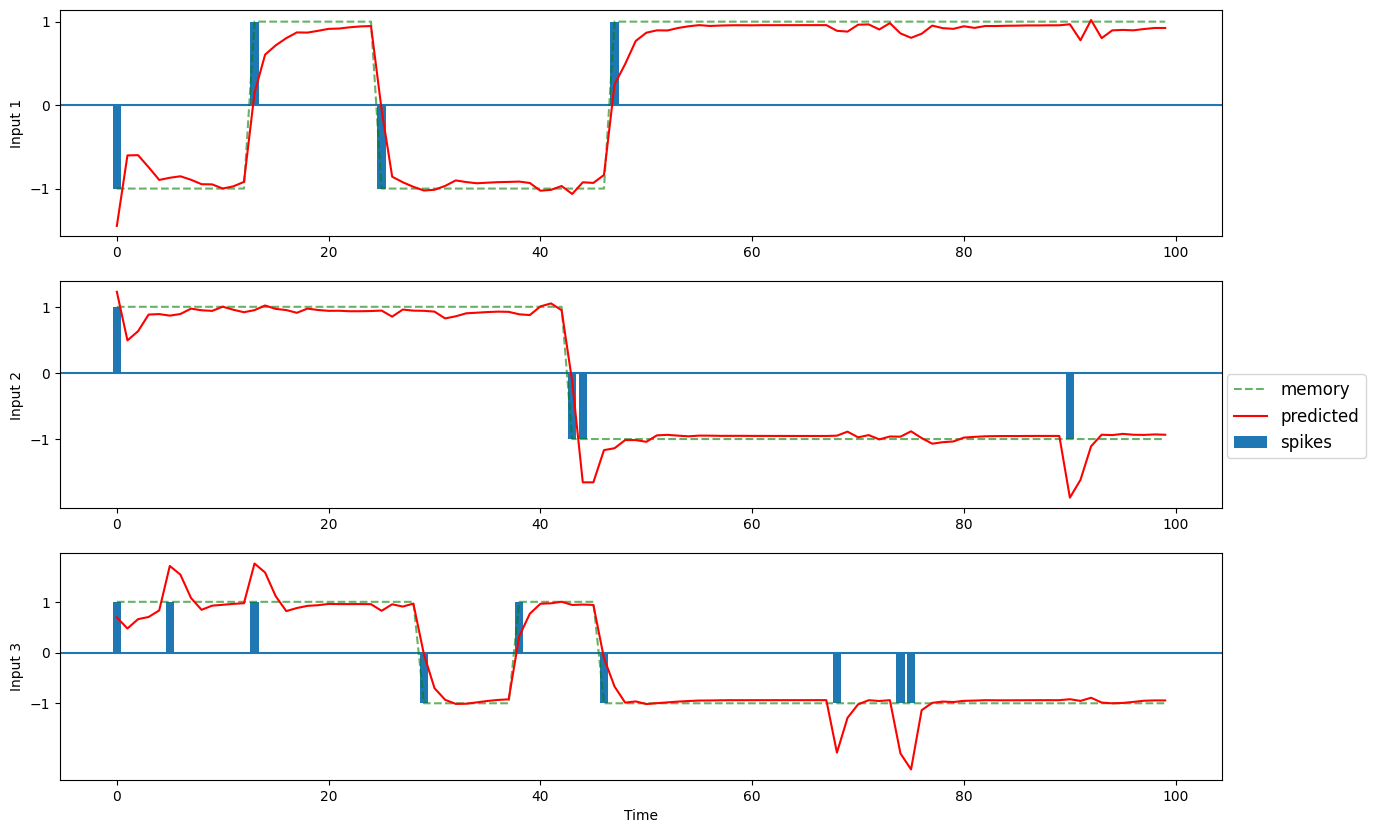

 40%|████      | 1200/3000 [14:43<21:27,  1.40it/s]

4 /10 --- loss = 0.045346


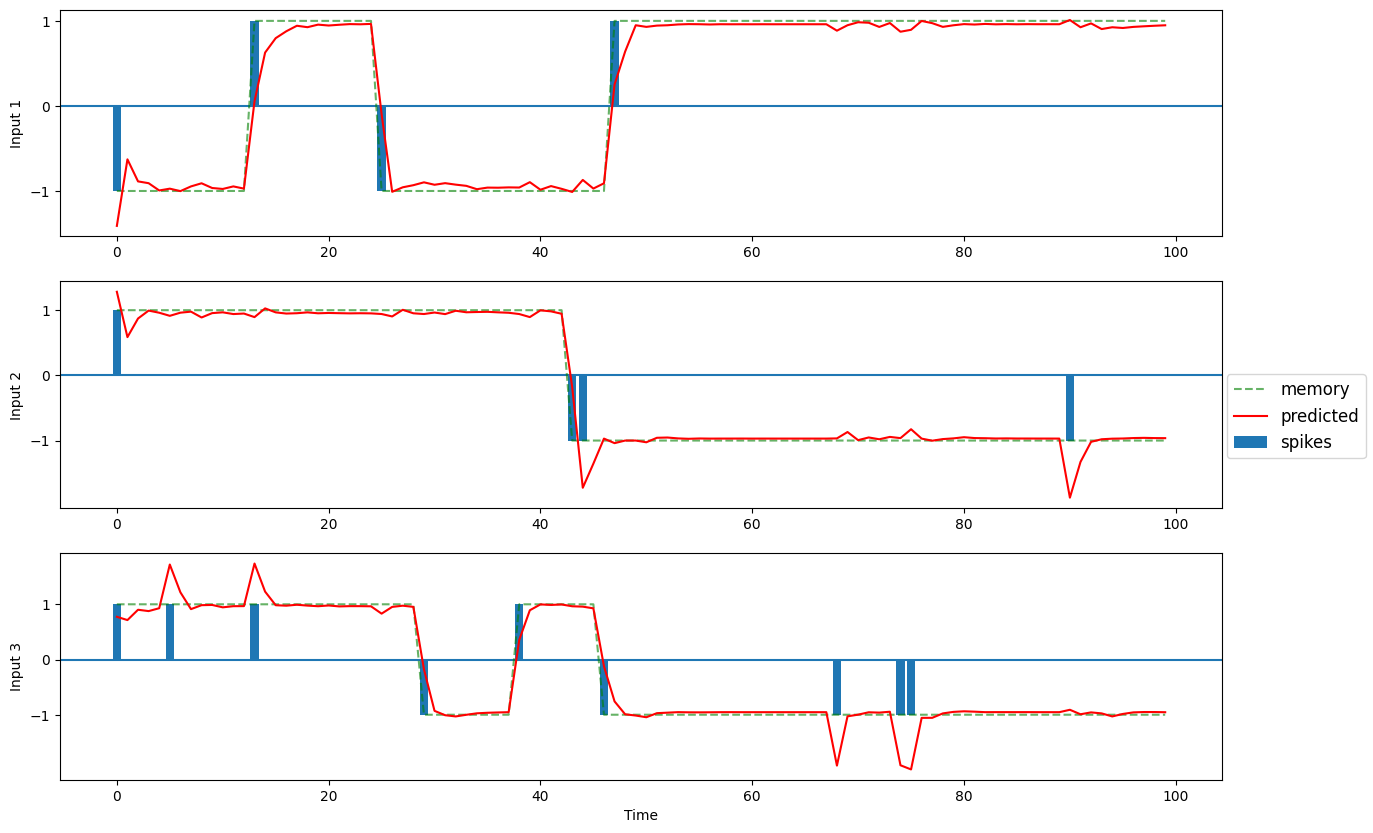

 50%|█████     | 1500/3000 [18:20<18:11,  1.37it/s]

5 /10 --- loss = 0.029316


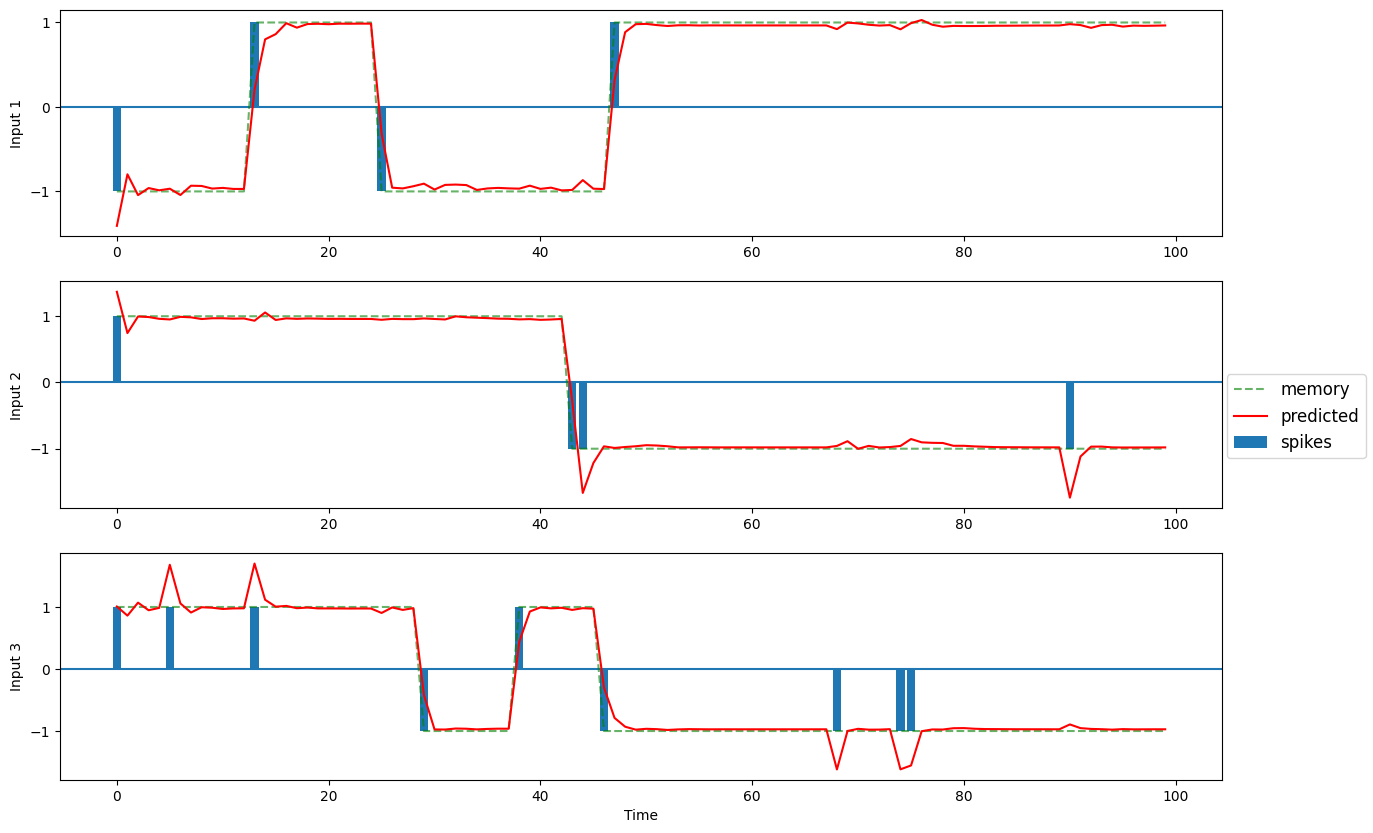

 60%|██████    | 1800/3000 [22:05<15:01,  1.33it/s]

6 /10 --- loss = 0.013221


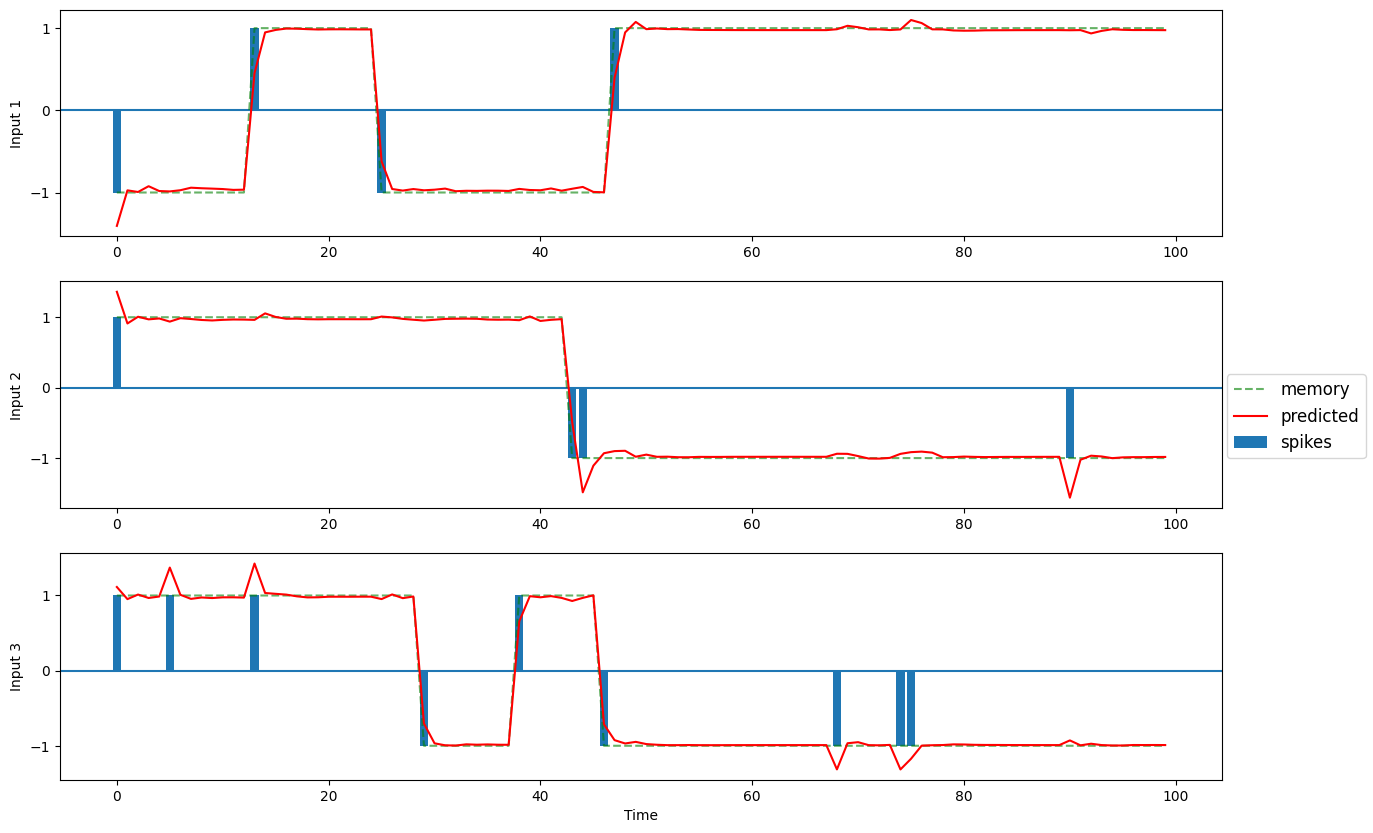

 70%|███████   | 2100/3000 [25:49<11:00,  1.36it/s]

7 /10 --- loss = 0.003422


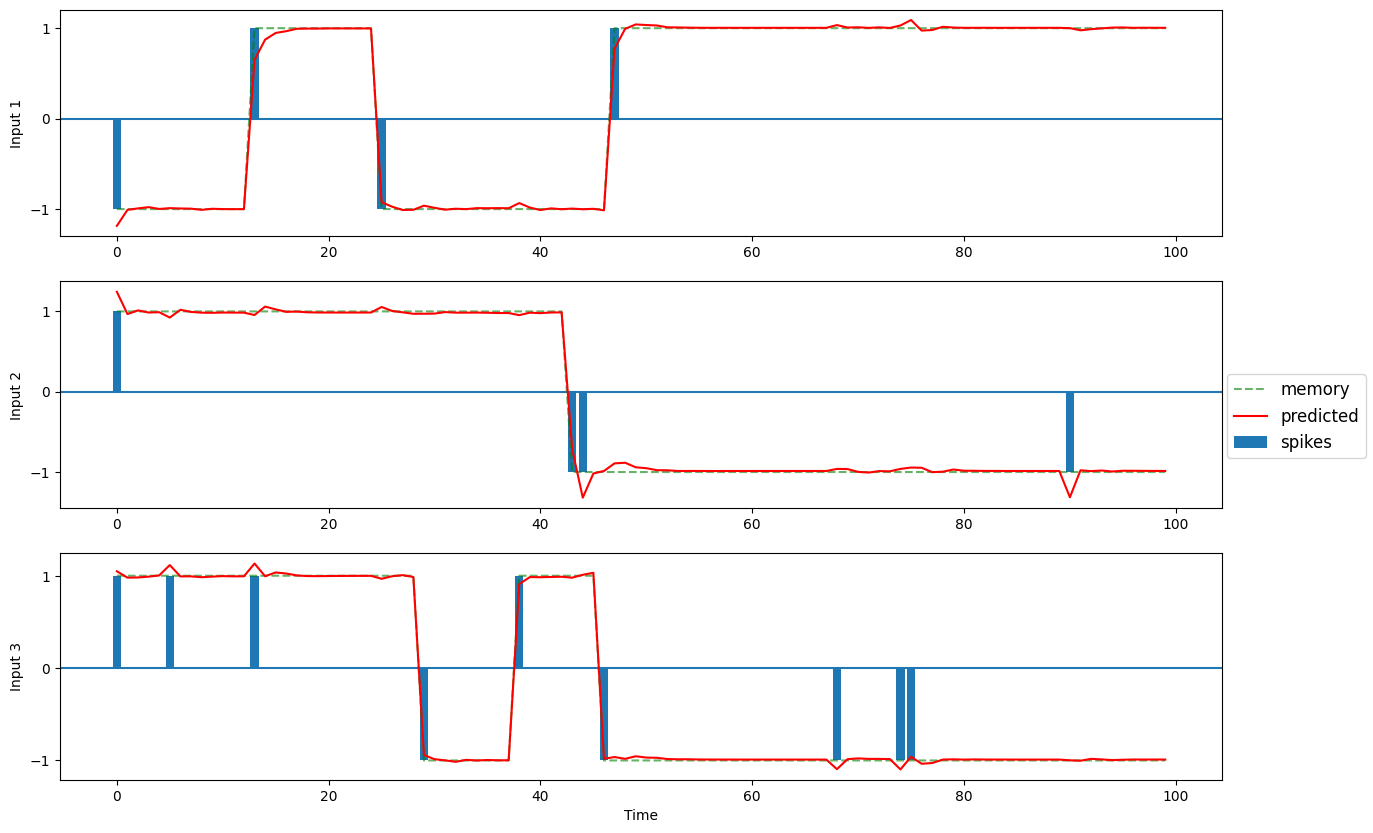

 80%|████████  | 2400/3000 [29:32<07:15,  1.38it/s]

8 /10 --- loss = 0.000568


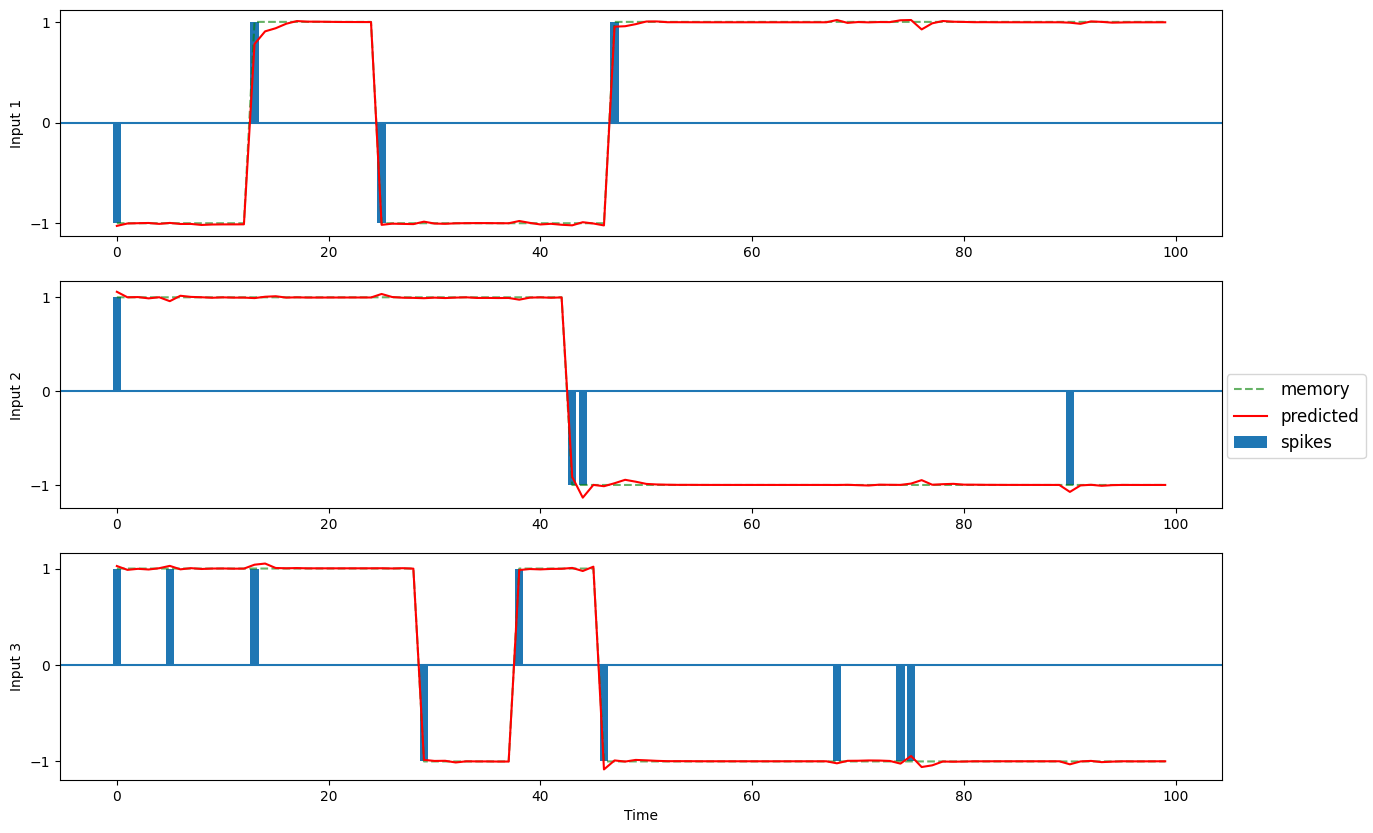

 90%|█████████ | 2700/3000 [33:14<03:37,  1.38it/s]

9 /10 --- loss = 0.000183


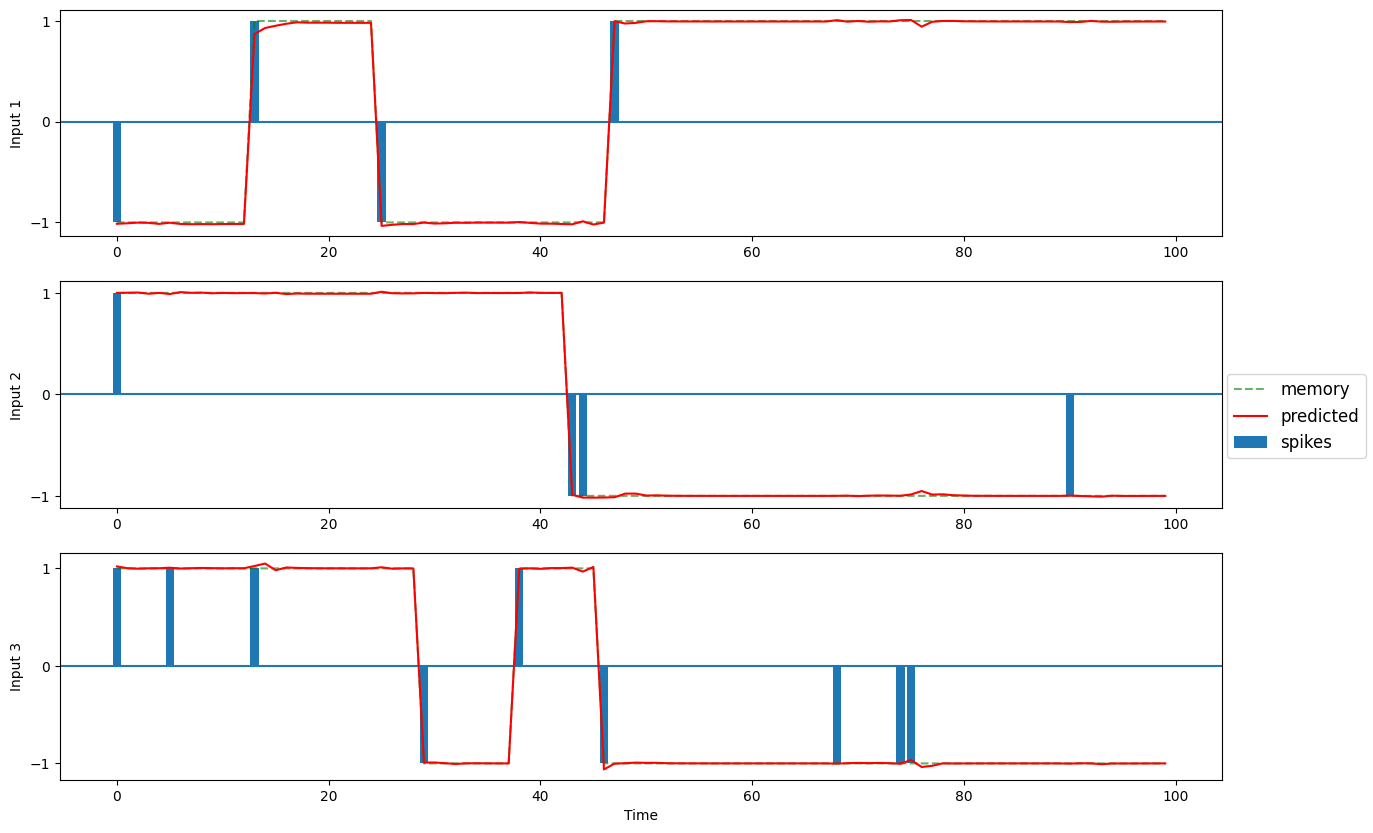

100%|██████████| 3000/3000 [36:55<00:00,  1.35it/s]

Loss:  7.068771083140746e-05


In [28]:
random.seed(0)
np.random.seed(0)
torch.manual_seed(0)

# k - flip-flop
K = 3
T = 100

# decide on hyperparameters
input_size=K
output_size=K
hidden_dim=30
n_layers=1

tb_rnn = Three_Bodies_RNN(input_size, output_size, hidden_dim).to(DEVICE)

# MSE loss and Adam optimizer with a learning rate
criterion = nn.MSELoss().to(DEVICE)
optimizer = torch.optim.Adam(tb_rnn.parameters(), lr=1e-04)

# train parameters
n_steps = 3000
n_batch = 1000

# T time steps
time_steps = np.arange(T)

# generate new data
Inputs, Targets = generate_data(n_batch,T,K)

losses = tb_rnn.train(Inputs,Targets,n_steps,n_batch,optimizer,criterion,T)

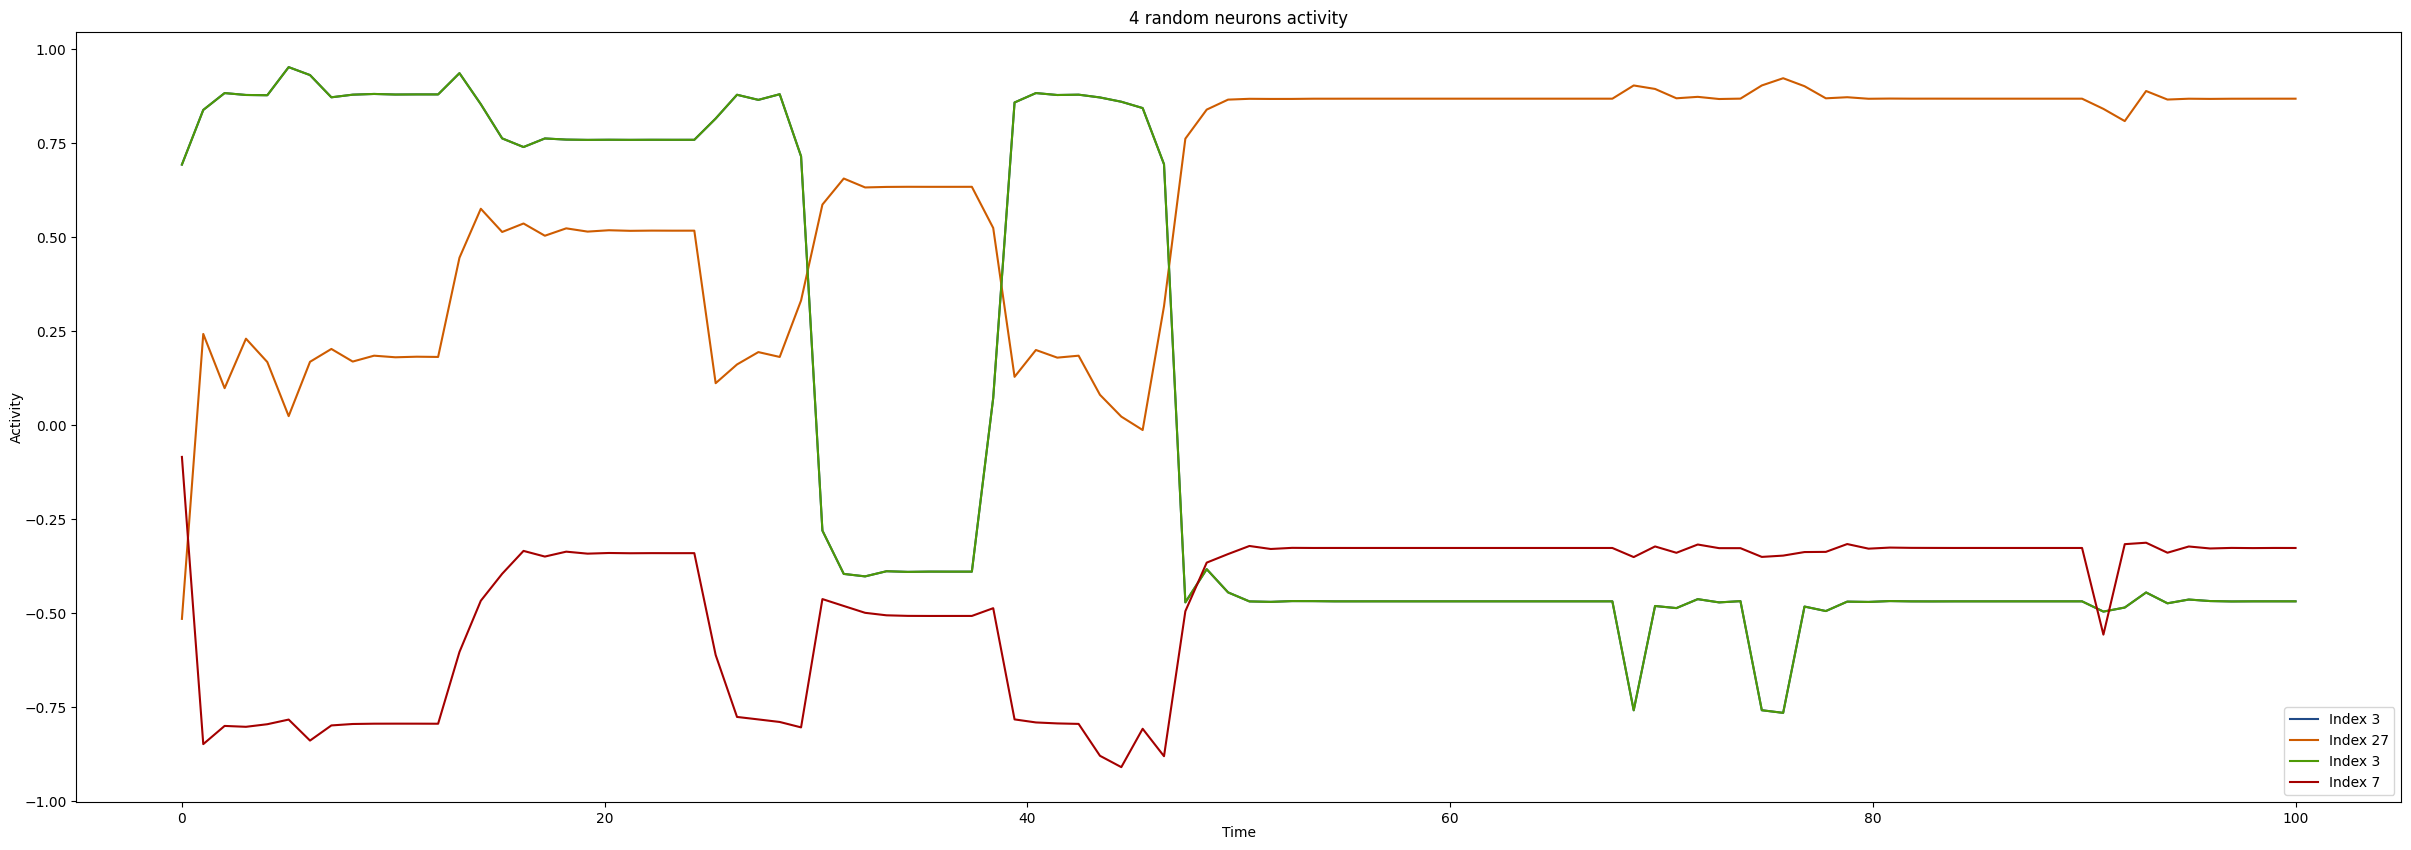

In [77]:
print_rand_neurons(tb_rnn,4,hidden_dim,100,Inputs)

<ipython-input-68-3290ac170135>:19: MatplotlibDeprecationWarning: The dist attribute was deprecated in Matplotlib 3.6 and will be removed two minor releases later.
  ax.dist = 12


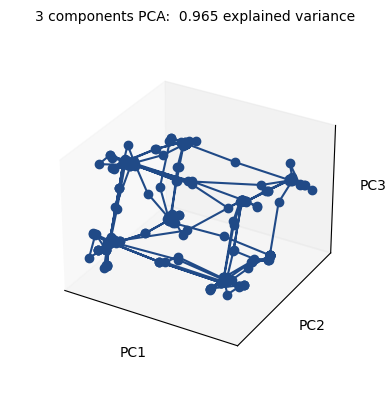

In [68]:
idx=8
R = tb_rnn(Inputs2,None)[2][idx].cpu().transpose(0,1)

pca=PCA(n_components=30)
pca.fit(R.detach().numpy().T)

variance = pca.explained_variance_ratio_.cumsum()

V=pca.transform(R.detach().numpy().T)

fig = plt.figure()
ax = plt.axes(projection='3d')

# Plot every int_t = 10 steps
int_t = 1
ax.plot(V[::int_t,0],V[::int_t,1],V[::int_t,2], '-o',color = colors[0])

plt.rcParams['axes.labelpad'] = 0.1
ax.dist = 12

ax.grid('off')

ax.set_xticks([])
ax.set_yticks([])
ax.set_zticks([])

ax.set_xlabel('PC1')
ax.set_ylabel('PC2')
ax.set_zlabel('PC3')

ax.set_title("3 components PCA: {var: .3g} explained variance".format(var = variance[2]),fontsize=10)

plt.show()

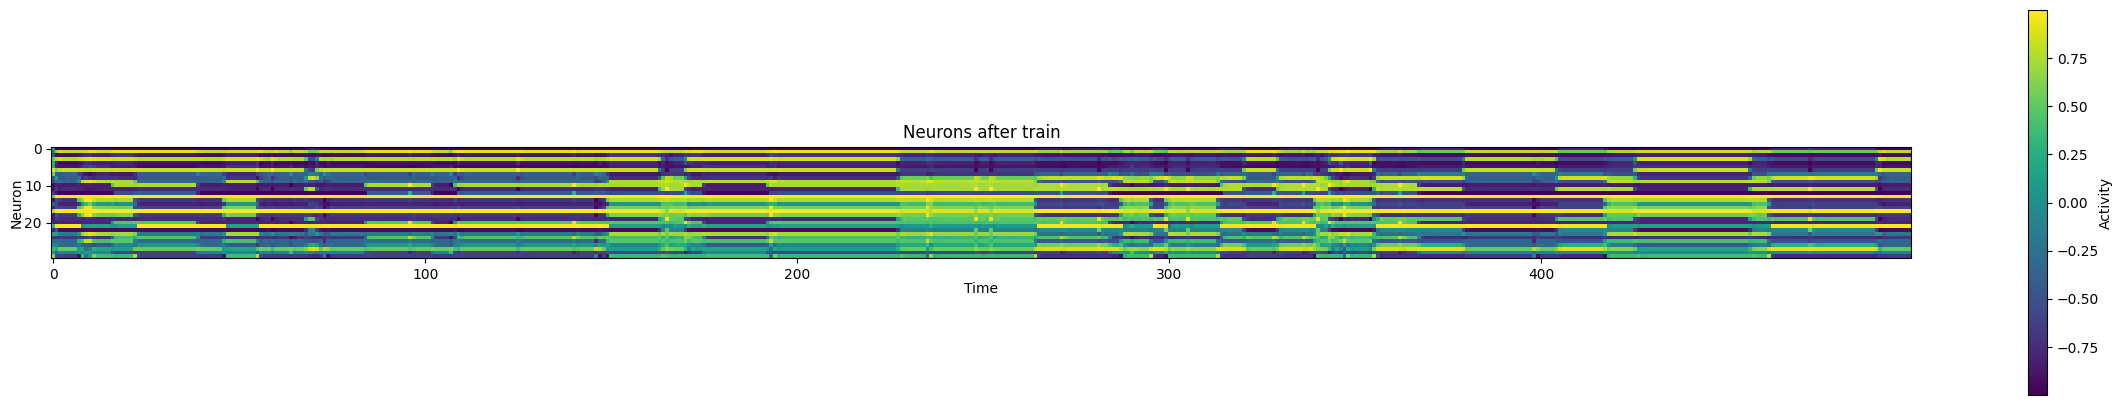

In [85]:
show_neurons(model,Inputs2,T=1000)

In [74]:
torch.save(tb_rnn.state_dict(),"/content/drive/MyDrive/Three_Bodies_Network/models/Tb_Rnn_K3_Tanh.pth")

In [84]:
model = Three_Bodies_RNN(input_size, output_size, hidden_dim).to(DEVICE)
model.load_state_dict(torch.load(f"/content/drive/MyDrive/Three_Bodies_Network/models/Tb_Rnn_K3_Tanh.pth"))

<All keys matched successfully>

  0%|          | 0/1000 [00:00<?, ?it/s]

0 /10 --- loss = 0.000069


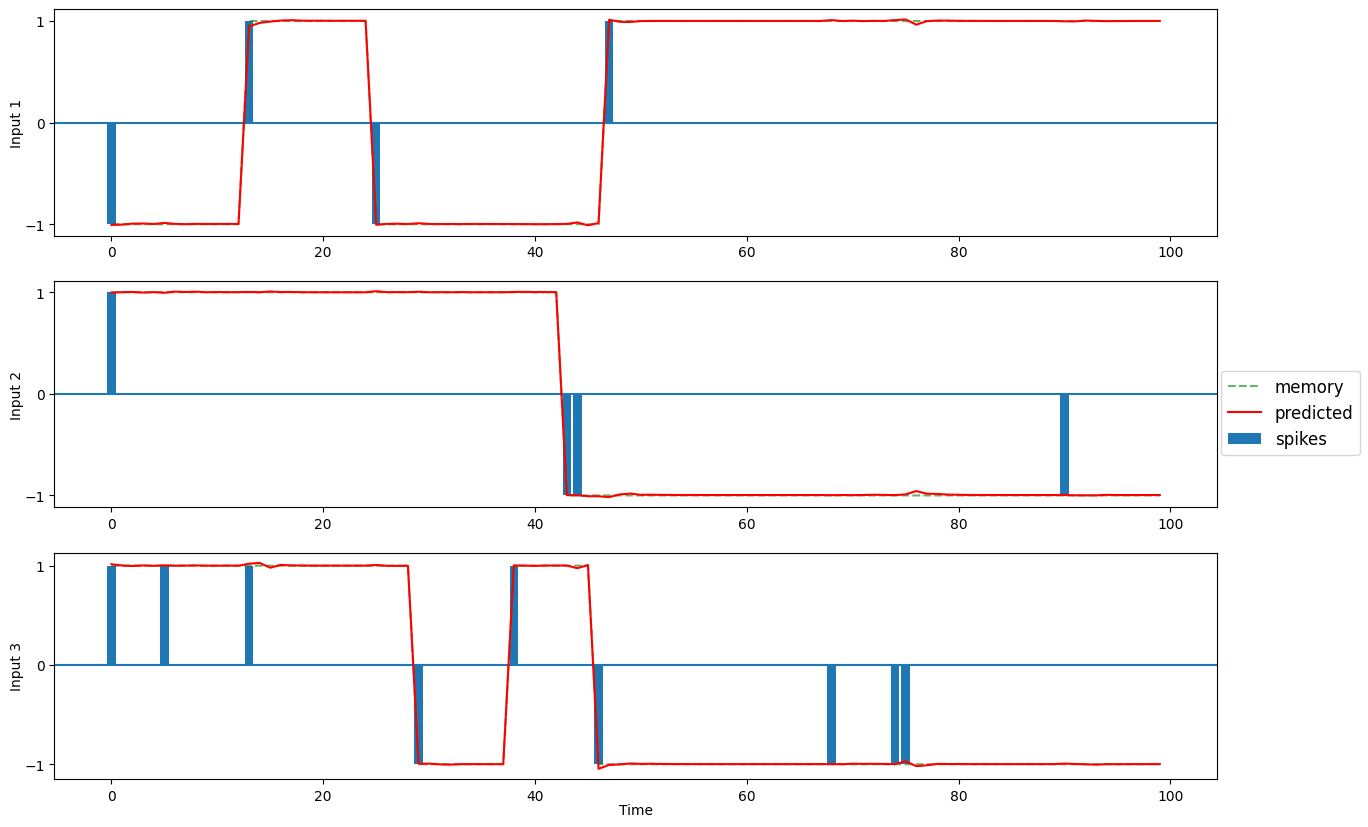

 10%|█         | 100/1000 [01:17<11:39,  1.29it/s]

1 /10 --- loss = 0.000064


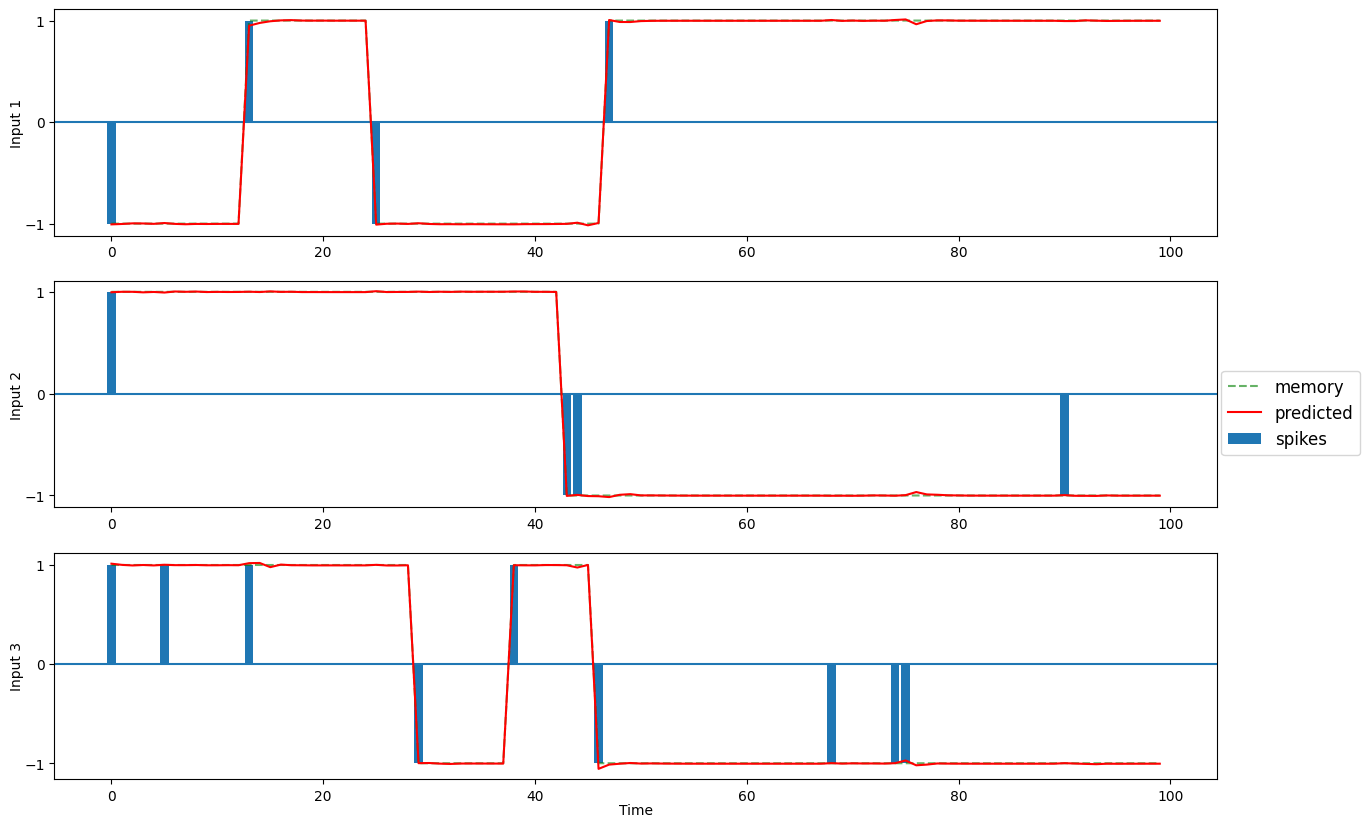

 20%|██        | 200/1000 [02:34<10:10,  1.31it/s]

2 /10 --- loss = 0.000061


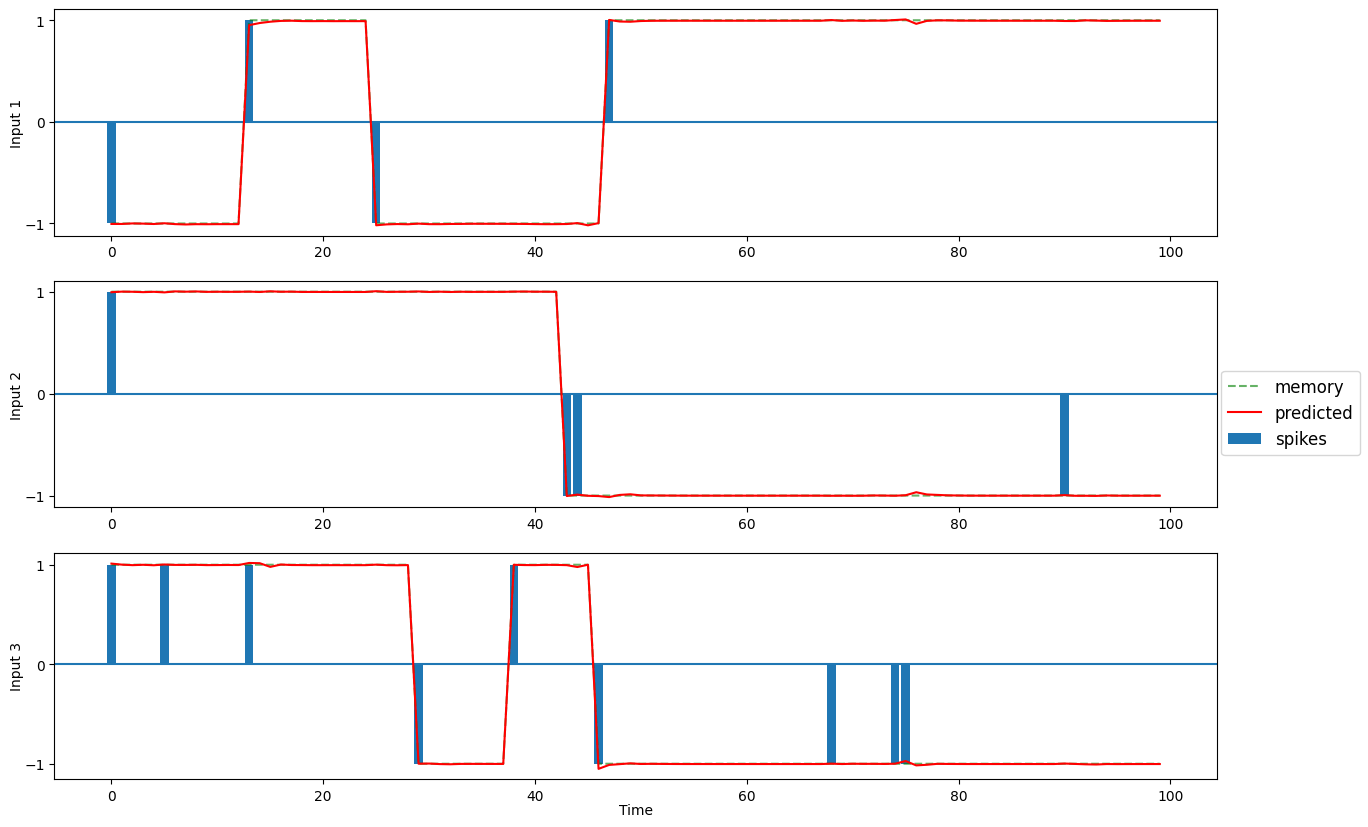

 30%|███       | 300/1000 [03:52<08:44,  1.34it/s]

3 /10 --- loss = 0.000065


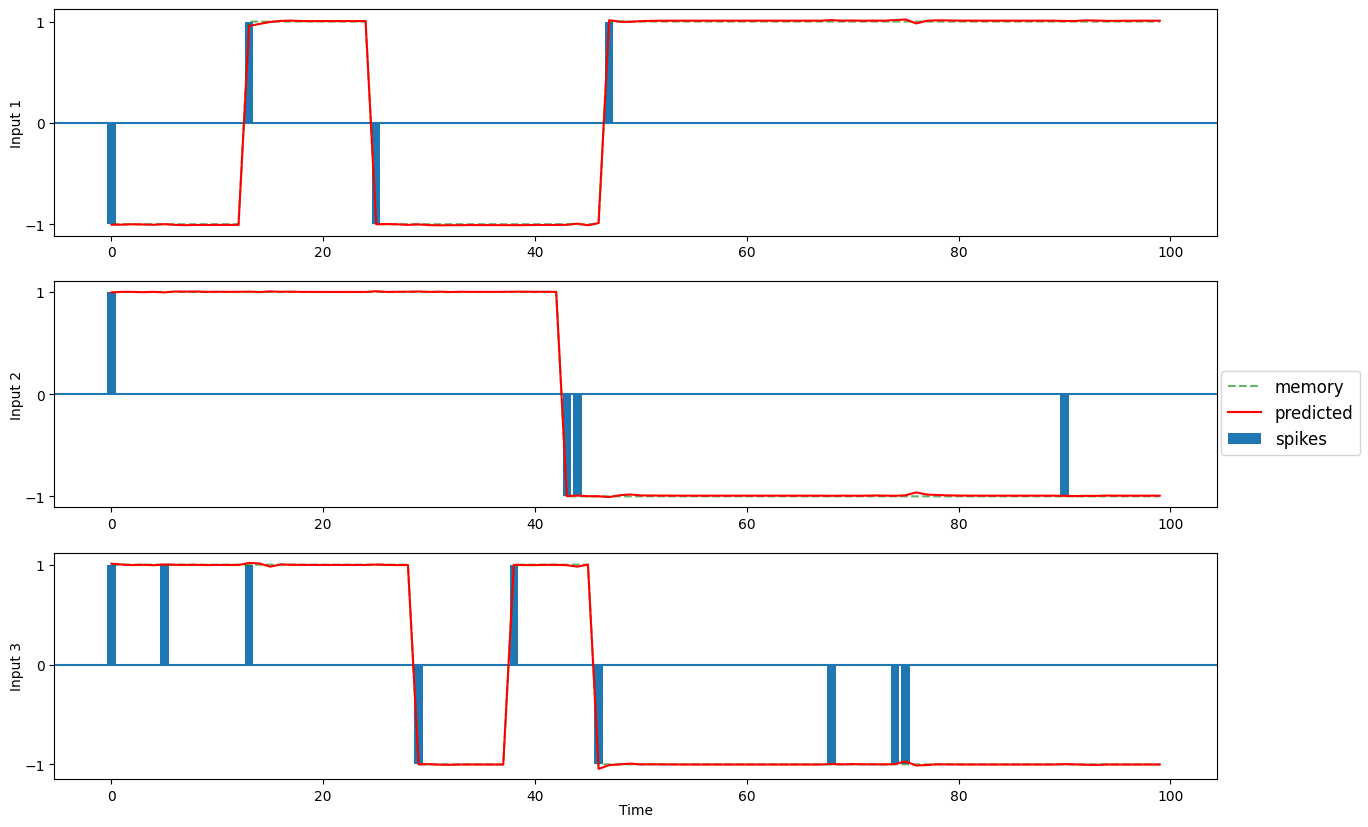

 40%|████      | 400/1000 [05:10<07:37,  1.31it/s]

4 /10 --- loss = 0.000038


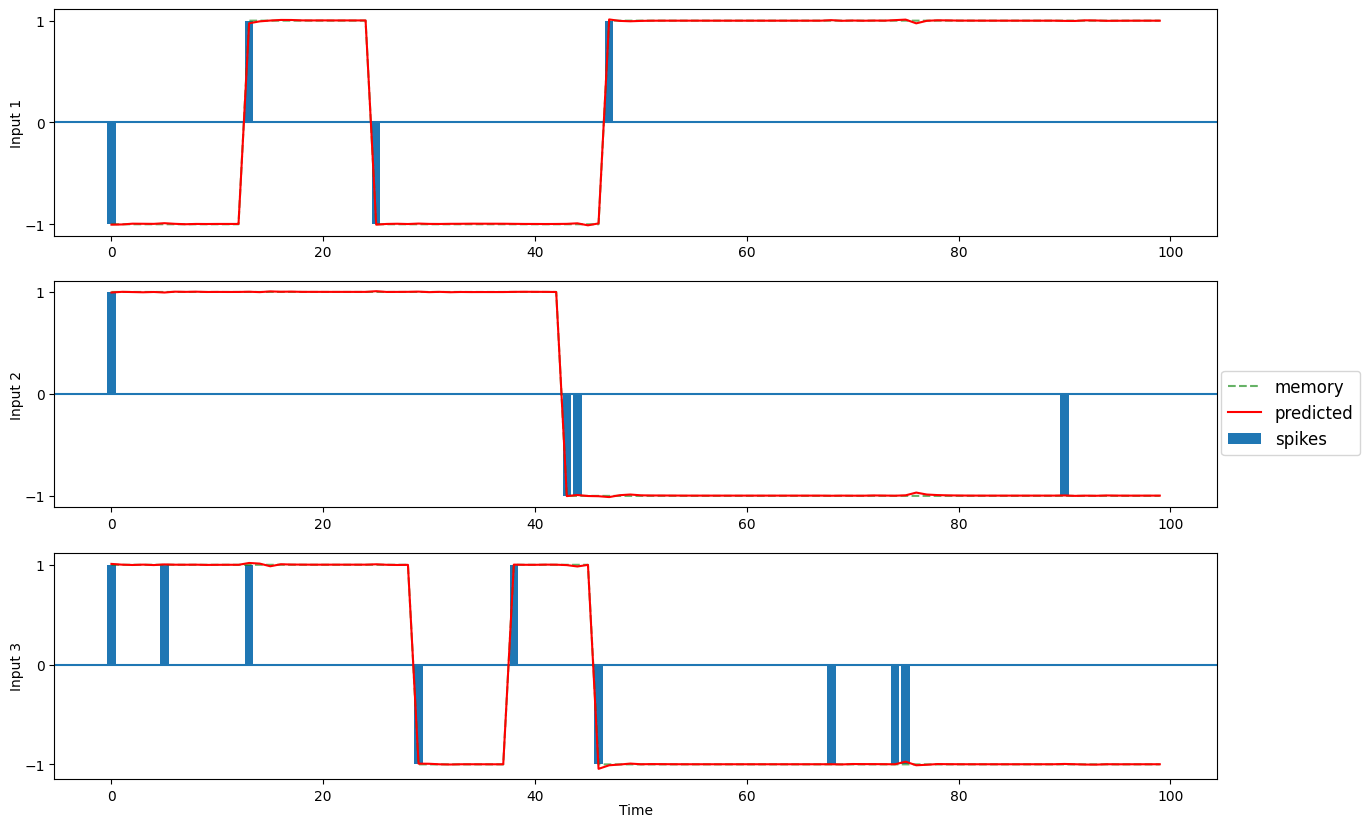

 50%|█████     | 500/1000 [06:28<06:16,  1.33it/s]

5 /10 --- loss = 0.000030


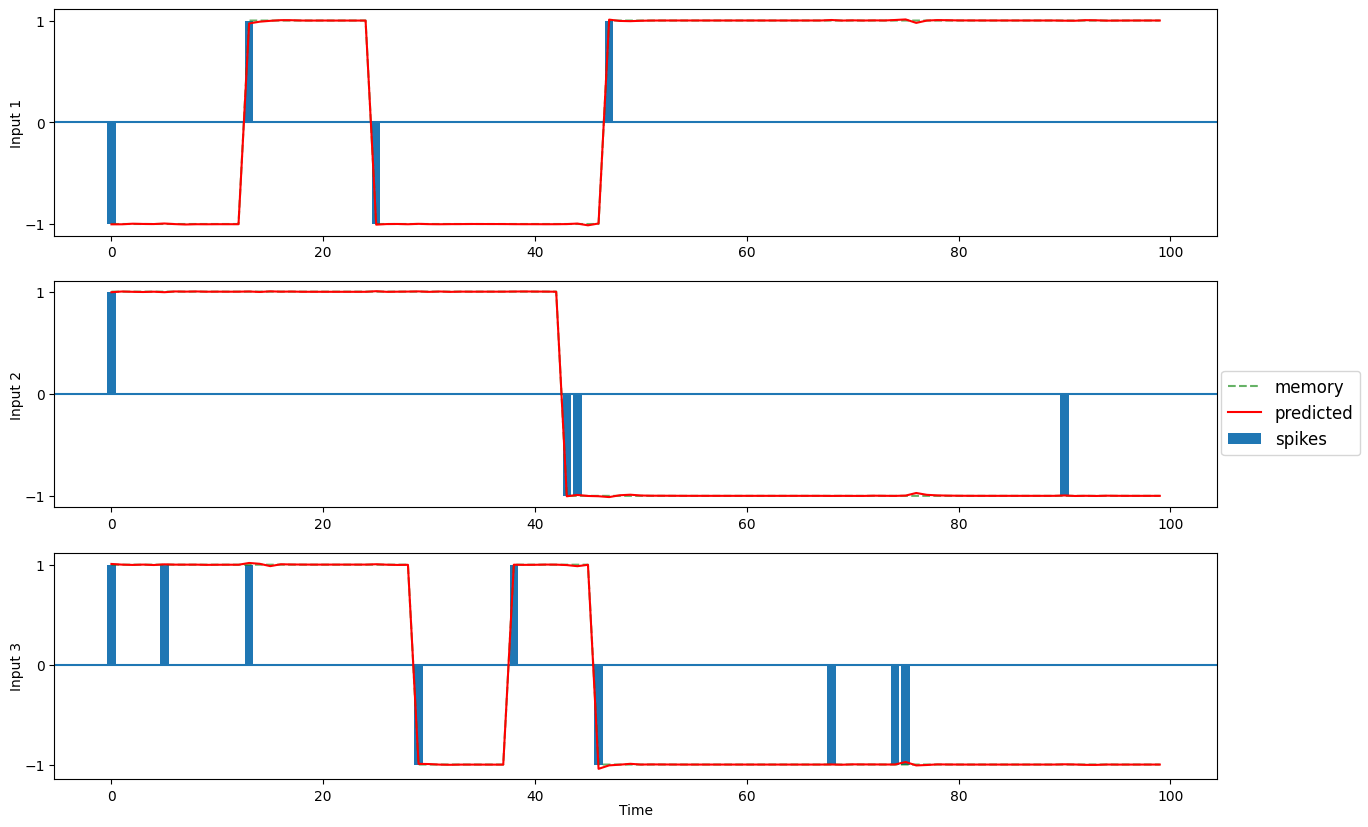

 60%|██████    | 600/1000 [07:45<05:06,  1.30it/s]

6 /10 --- loss = 0.000049


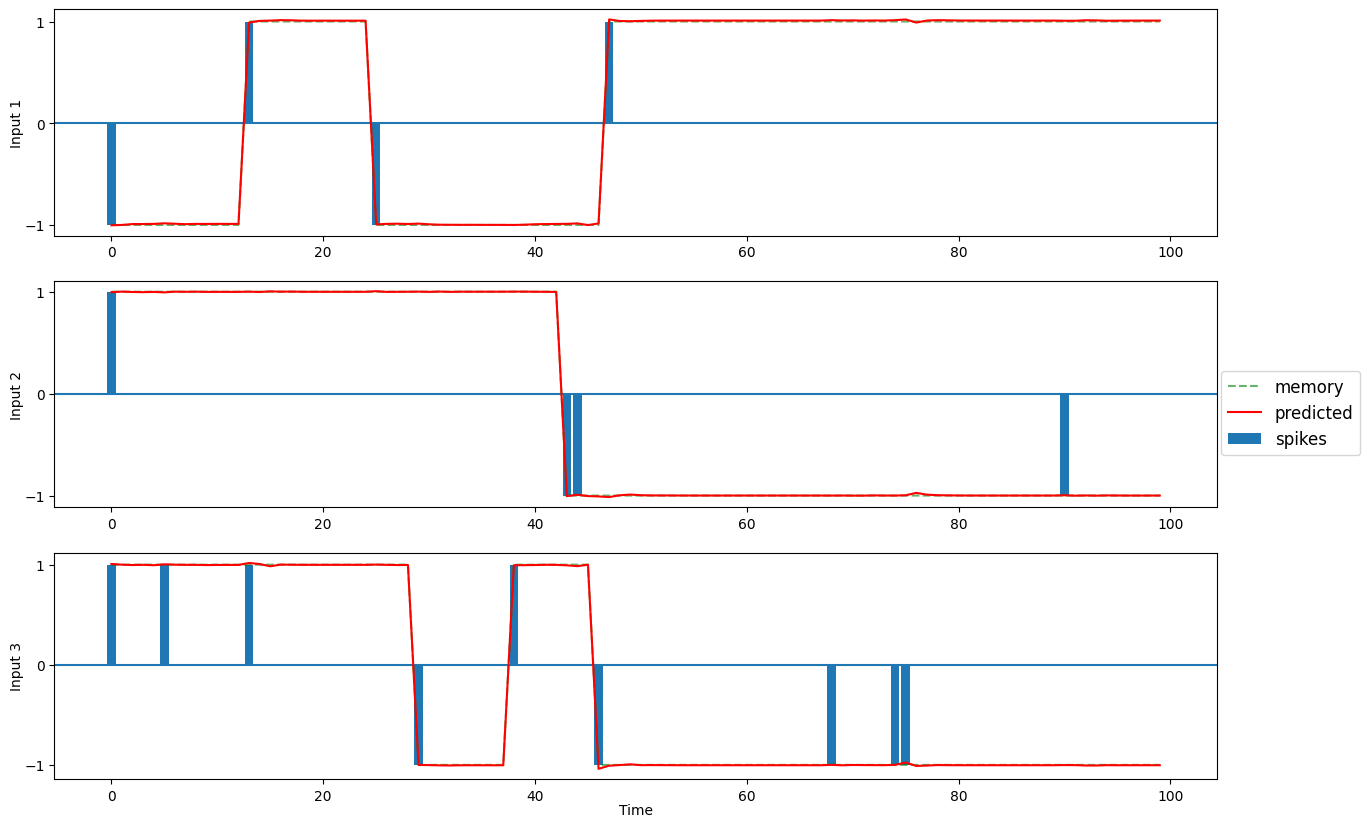

 70%|███████   | 700/1000 [09:03<03:53,  1.28it/s]

7 /10 --- loss = 0.000026


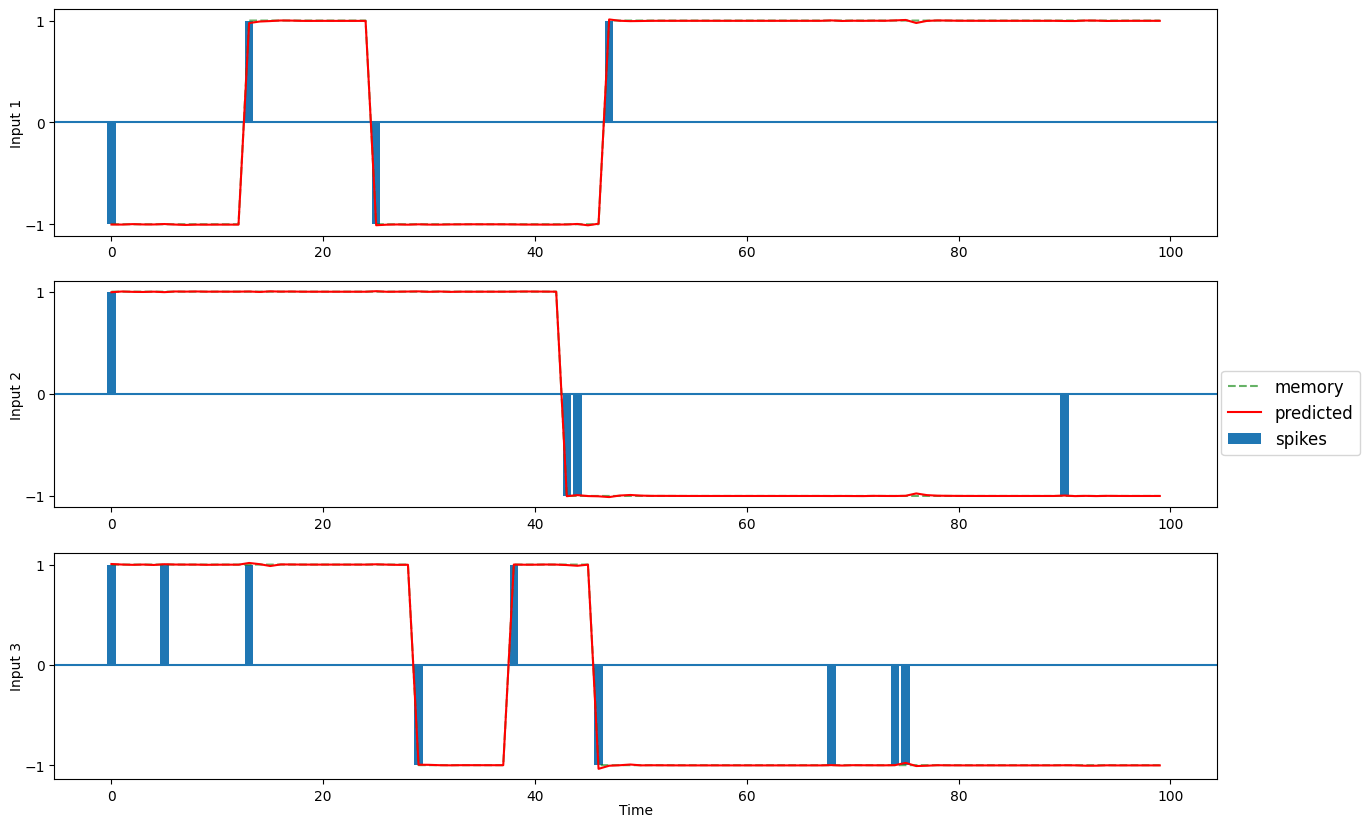

 80%|████████  | 800/1000 [10:21<02:35,  1.29it/s]

8 /10 --- loss = 0.000022


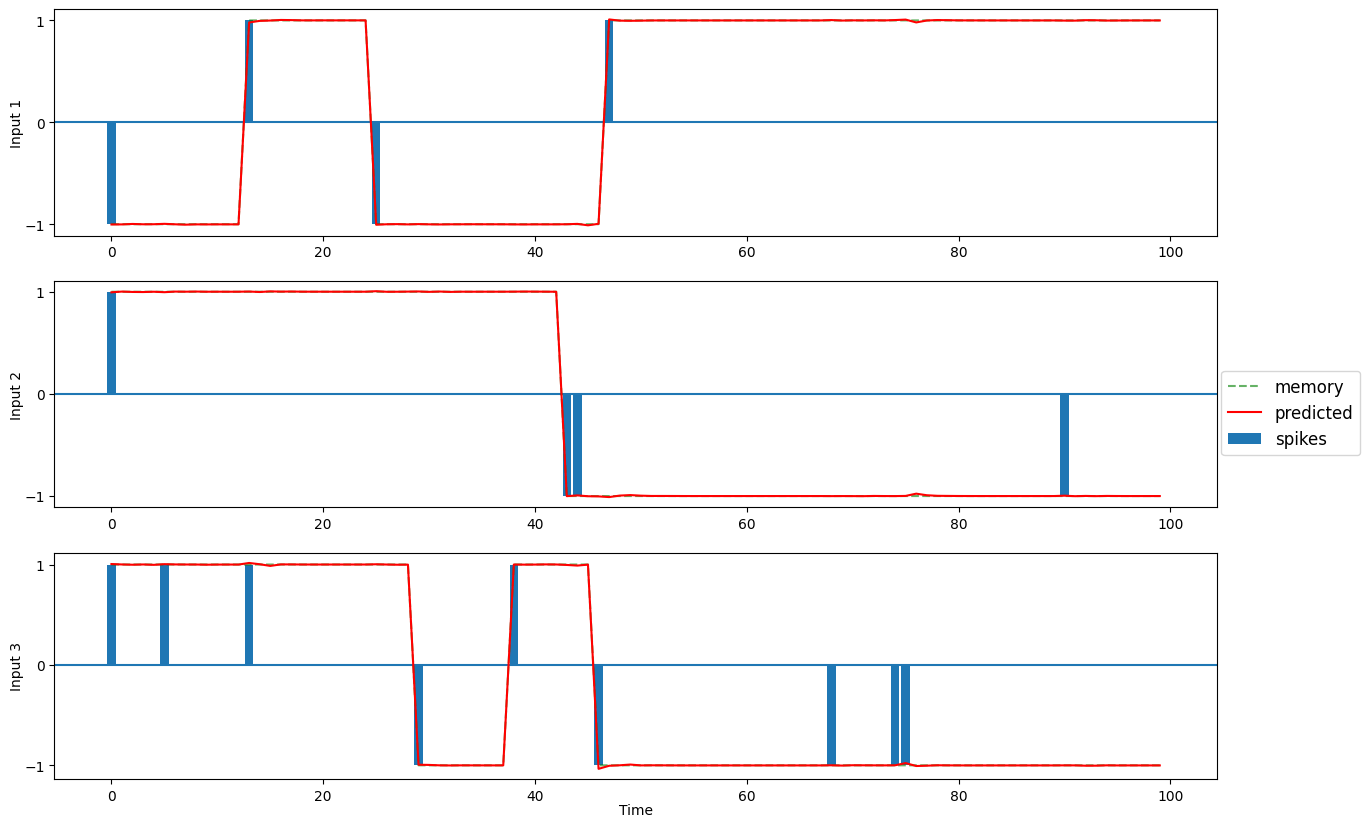

 90%|█████████ | 900/1000 [11:39<01:15,  1.32it/s]

9 /10 --- loss = 0.000026


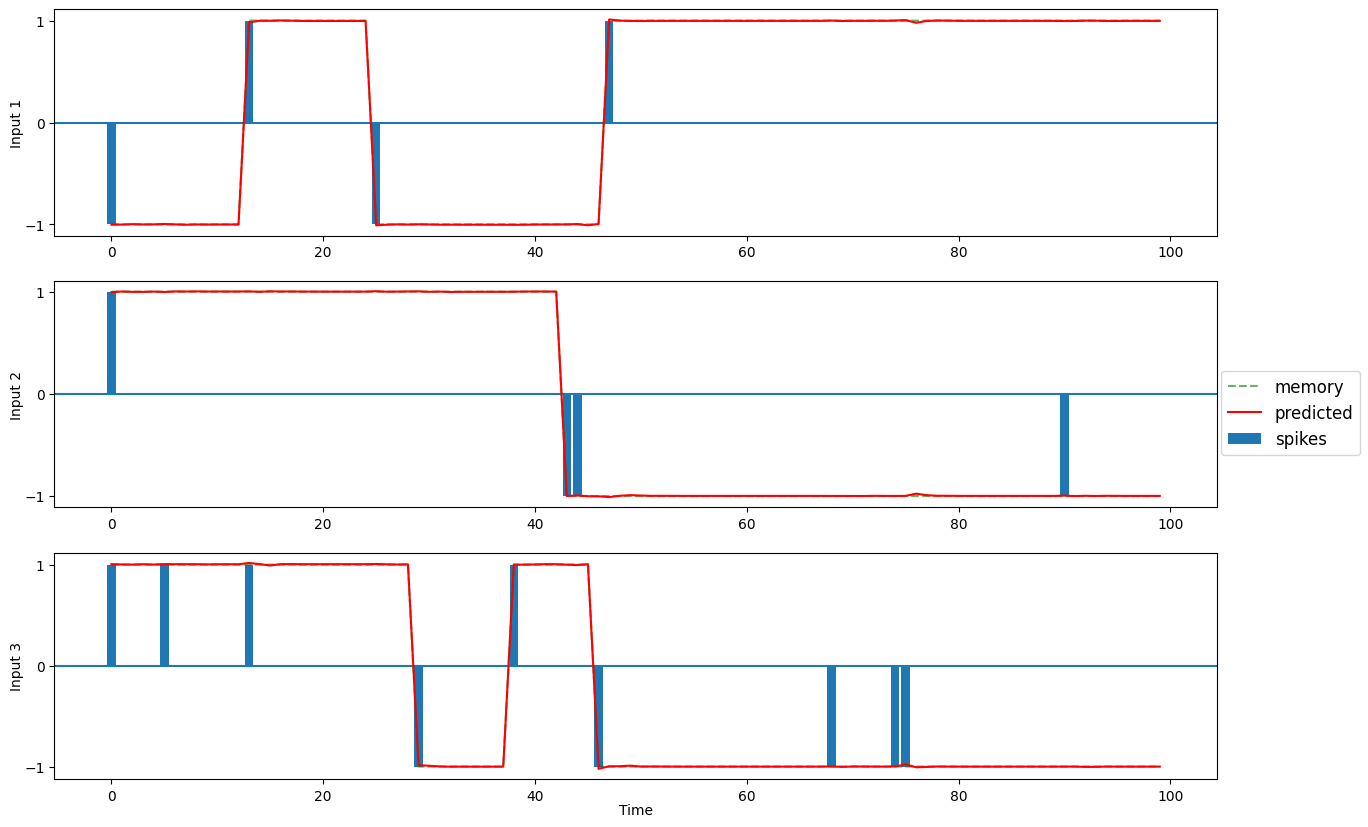

100%|██████████| 1000/1000 [12:57<00:00,  1.29it/s]

Loss:  2.2873357011121698e-05


[6.929301889613271e-05,
 6.397507968358696e-05,
 6.129971006885171e-05,
 6.532994302688166e-05,
 3.757911690627225e-05,
 3.0432656785706058e-05,
 4.922883817926049e-05,
 2.551798206695821e-05,
 2.1809701138408855e-05,
 2.5698884201119654e-05]

In [71]:
tb_rnn.train(Inputs,Targets,1000,n_batch,optimizer,criterion,T)

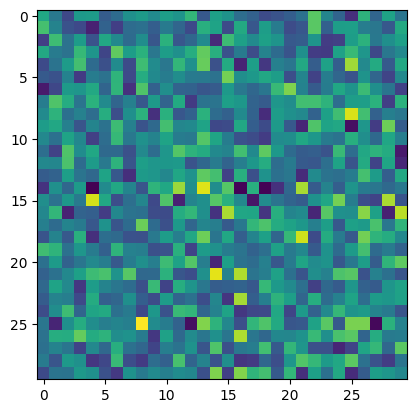

In [72]:
plt.imshow(tb_rnn.three_way_tensor[16].cpu().detach().numpy())

In [7]:
mount_colab()
model = load_model(3,30,"Tb_Rnn_K3_Tanh")[0]

Mounted at /content/drive
cp: cannot open '/content/drive/MyDrive/בקשה-ללמוד-קורס-במוסד-אחר (1).gdoc' for reading: Operation not supported
cp: cannot open '/content/drive/MyDrive/בקשה-ללמוד-קורס-במוסד-אחר.gdoc' for reading: Operation not supported


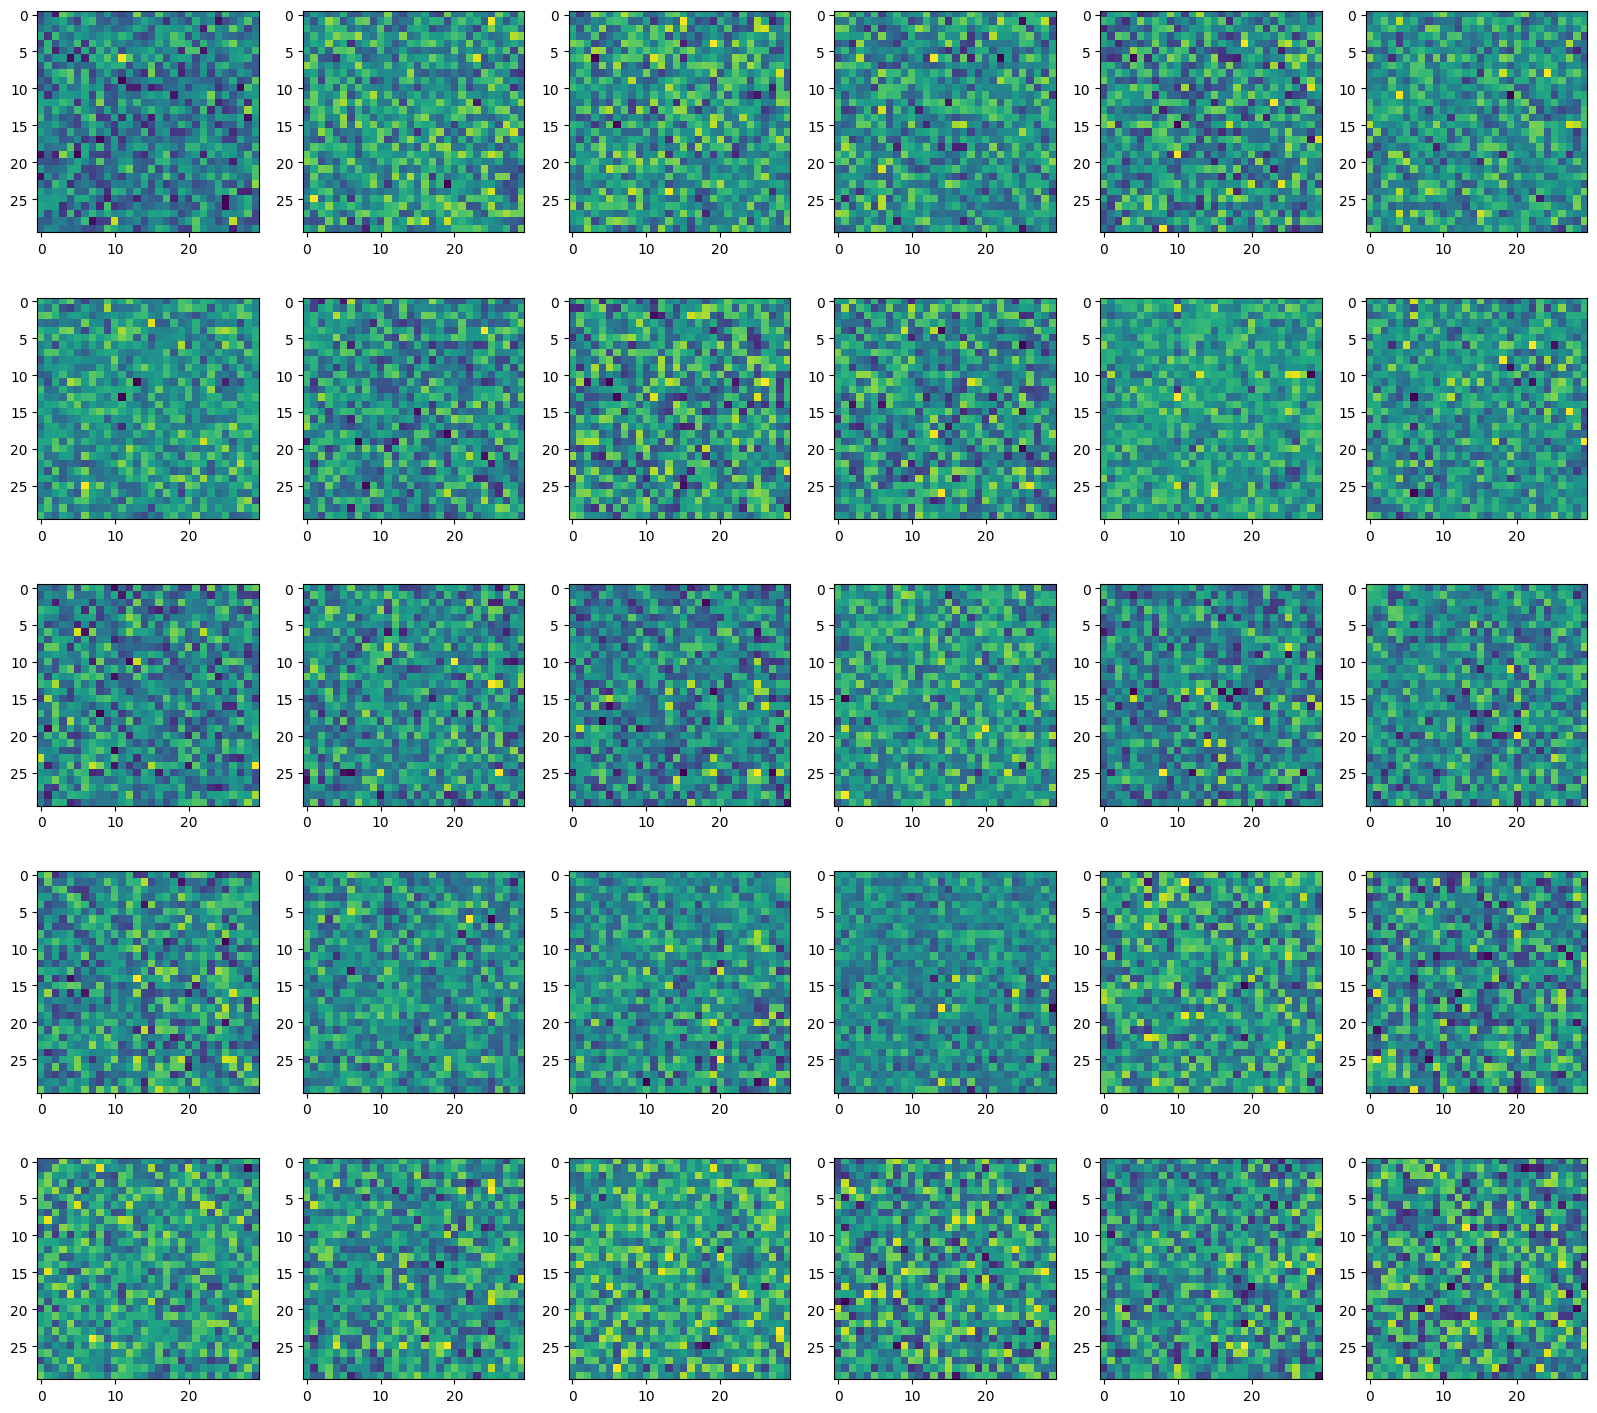

In [10]:
utils.show_connectivity(model,30,dim=0)

###Low rank RNN to mimic Full rank RNN

In [7]:
# k - flip-flop
K = 3
T = 100

# decide on hyperparameters
input_size=K
output_size=K
hidden_dim=30
n_layers=1

full_rank_rnn = Full_Rank_RNN(input_size,output_size,hidden_dim,nonlinearity = 'tanh',task = "FF").to(DEVICE)
full_rank_rnn.load_state_dict(torch.load(f"/content/drive/MyDrive/Three_Bodies_Network/Low_Rank_Rnn/Full_Rank_RNN.pth"))

# MSE loss and Adam optimizer with a learning rate
criterion = nn.MSELoss().to(DEVICE)

# train parameters
n_steps = 3000
n_batch = 128
batch_size=128

Inputs, Targets = K_Bit_Flipflop_task.generate_mem_data(n_batch,T,K)

ranks = 5
r_losses = []

lr = 1e-03

for rank in range(1,ranks+1):
  # instantiate an low rank RNN
  low_rank_rnn = Low_Rank_RNN(input_size, output_size, hidden_dim, rank,nonlinearity = torch.tanh, task = "FF").to(DEVICE)
  optimizer = torch.optim.Adam(low_rank_rnn.parameters(), lr=lr)
  losses = low_rank_rnn.lr_train(Inputs,Targets,full_rank_rnn,n_steps,optimizer,criterion,batch_size,T)
  r_losses.append(losses)
  torch.save(low_rank_rnn.state_dict(), f'/content/drive/MyDrive/Three_Bodies_Network/Low_Rank_Rnn/Rank_{rank}_RNN_new.pth')

Output hidden; open in https://colab.research.google.com to view.

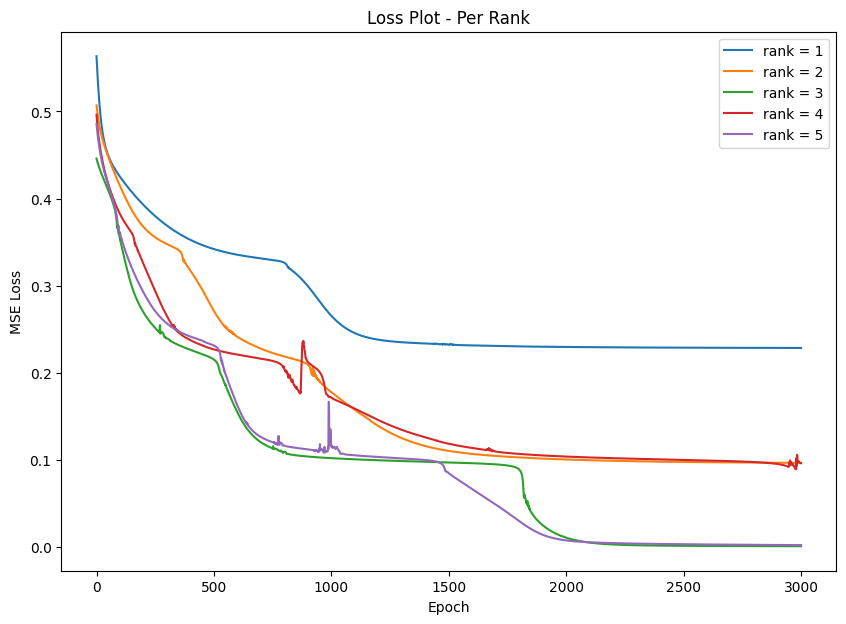

In [15]:
fig = plt.figure(figsize=(10,7))
ax = fig.add_subplot(1,1,1)
for rank in range(ranks):
  _=ax.plot(r_losses[rank],label = f'rank = {rank+1}')
_=ax.set_title("Loss Plot - Per Rank")
_=ax.set_xlabel("Epoch")
_=ax.set_ylabel("MSE Loss")
_=ax.legend()

### Low Rank Three Bodies RNN to mimic Full Rank Three Bodies RNN

####sigmoid, K=3, rank 1-10

In [6]:
# k - flip-flop
K = 3
T = 100

# decide on hyperparameters
input_size=K
output_size=K
hidden_dim=30

full_rank_rnn = Three_Bodies_RNN(input_size,output_size,hidden_dim,nonlinearity = torch.sigmoid,task = "FF").to(DEVICE)
full_rank_rnn.load_state_dict(torch.load(f"/content/drive/MyDrive/Three_Bodies_Network/models/three_body_RNN_K3.pth"))

# MSE loss and Adam optimizer with a learning rate
criterion = nn.MSELoss().to(DEVICE)

# train parameters
n_steps = 6000
n_batch = 128
batch_size=128

Inputs, Targets = K_Bit_Flipflop_task.generate_mem_data(n_batch,T,K)

ranks = 10
r_losses = []

lr = 1e-03

for rank in range(1,ranks+1):
  # instantiate an low rank RNN
  low_rank_rnn = Low_Rank_Three_Way_RNN(input_size, output_size, hidden_dim, rank,nonlinearity = torch.sigmoid, task = "FF").to(DEVICE)
  optimizer = torch.optim.Adam(low_rank_rnn.parameters(), lr=lr)
  losses = low_rank_rnn.lr_train(Inputs,Targets,full_rank_rnn,n_steps,optimizer,criterion,batch_size,T)
  r_losses.append(losses)
  torch.save(low_rank_rnn.state_dict(), f'/content/drive/MyDrive/Three_Bodies_Network/Low_Rank_Rnn/Three_Way_Rank_{rank}_RNN_new.pth')

Output hidden; open in https://colab.research.google.com to view.

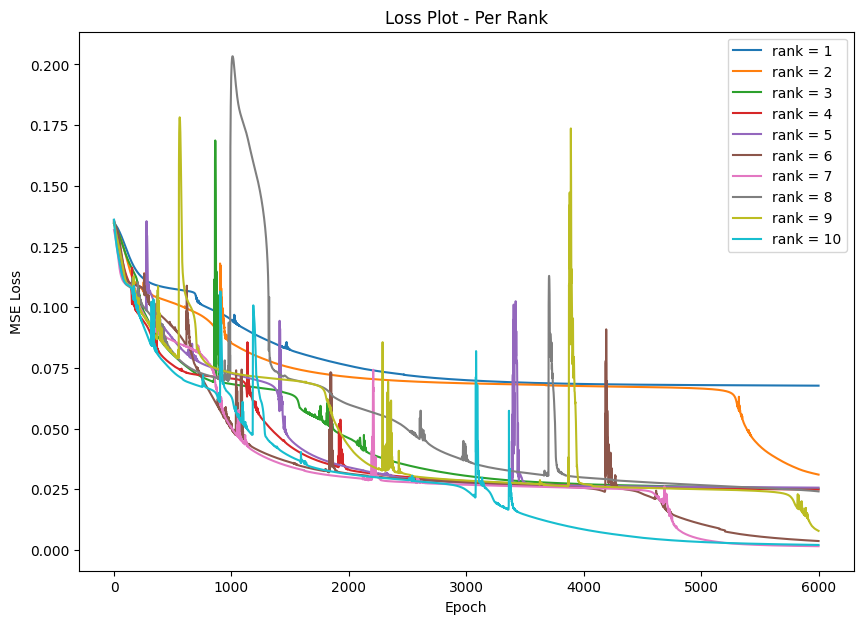

In [7]:
fig = plt.figure(figsize=(10,7))
ax = fig.add_subplot(1,1,1)
for rank in range(ranks):
  _=ax.plot(r_losses[rank],label = f'rank = {rank+1}')
_=ax.set_title("Loss Plot - Per Rank")
_=ax.set_xlabel("Epoch")
_=ax.set_ylabel("MSE Loss")
_=ax.legend()

####Tanh, K=3, Rank 1-10

In [8]:
# k - flip-flop
K = 3
T = 100

# decide on hyperparameters
input_size=K
output_size=K
hidden_dim=30

full_rank_rnn = Three_Bodies_RNN(input_size,output_size,hidden_dim,nonlinearity = torch.tanh,task = "FF").to(DEVICE)
full_rank_rnn.load_state_dict(torch.load(f"/content/drive/MyDrive/Three_Bodies_Network/models/Tb_Rnn_K3_Tanh.pth"))

# MSE loss and Adam optimizer with a learning rate
criterion = nn.MSELoss().to(DEVICE)

# train parameters
n_steps = 6000
n_batch = 128
batch_size=128

Inputs, Targets = K_Bit_Flipflop_task.generate_mem_data(n_batch,T,K)

ranks = 10
r_losses = []

lr = 1e-03

for rank in range(1,ranks+1):
  # instantiate an low rank RNN
  low_rank_rnn = Low_Rank_Three_Way_RNN(input_size, output_size, hidden_dim, rank,nonlinearity = torch.tanh, task = "FF").to(DEVICE)
  optimizer = torch.optim.Adam(low_rank_rnn.parameters(), lr=lr)
  losses = low_rank_rnn.lr_train(Inputs,Targets,full_rank_rnn,n_steps,optimizer,criterion,batch_size,T)
  r_losses.append(losses)
  torch.save(low_rank_rnn.state_dict(), f'/content/drive/MyDrive/Three_Bodies_Network/Low_Rank_Rnn/Three_Way_Rank_{rank}_Mimic_Tanh_RNN.pth')

Output hidden; open in https://colab.research.google.com to view.

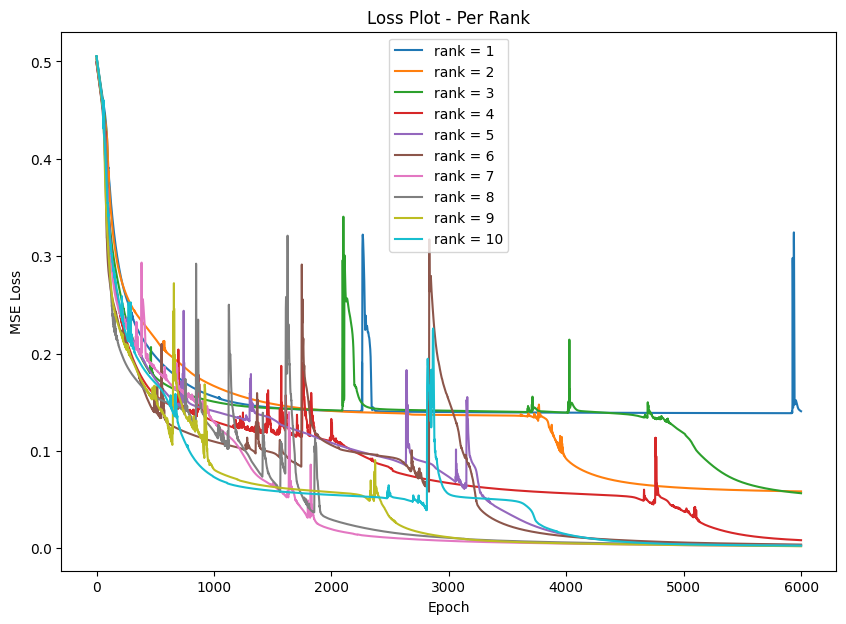

In [9]:
fig = plt.figure(figsize=(10,7))
ax = fig.add_subplot(1,1,1)
for rank in range(ranks):
  _=ax.plot(r_losses[rank],label = f'rank = {rank+1}')
_=ax.set_title("Loss Plot - Per Rank")
_=ax.set_xlabel("Epoch")
_=ax.set_ylabel("MSE Loss")
_=ax.legend()

### Low Rank RNN to mimic Full Rank Three Bodies RNN

####K=2, sigmoid

In [31]:
# k - flip-flop
K = 2
T = 100

# decide on hyperparameters
input_size=K
output_size=K
hidden_dim=30

full_rank_rnn = Three_Bodies_RNN(input_size,output_size,hidden_dim,nonlinearity = torch.sigmoid,task = "FF").to(DEVICE)
full_rank_rnn.load_state_dict(torch.load(f"/content/drive/MyDrive/Three_Bodies_Network/models/three_body_RNN_K2.pth"))

# MSE loss and Adam optimizer with a learning rate
criterion = nn.MSELoss().to(DEVICE)

# train parameters
n_steps = 6000
n_batch = 128
batch_size=128

Inputs, Targets = K_Bit_Flipflop_task.generate_mem_data(n_batch,T,K)

ranks = 10
r_losses = []

lr = 1e-03

for rank in range(1,ranks+1):
  # instantiate an low rank RNN
  low_rank_rnn = Low_Rank_RNN(input_size, output_size, hidden_dim, rank,nonlinearity = torch.sigmoid, task = "FF").to(DEVICE)
  optimizer = torch.optim.Adam(low_rank_rnn.parameters(), lr=lr)
  losses = low_rank_rnn.lr_train(Inputs,Targets,full_rank_rnn,n_steps,optimizer,criterion,batch_size,T)
  r_losses.append(losses)
  torch.save(low_rank_rnn.state_dict(), f'/content/drive/MyDrive/Three_Bodies_Network/Low_Rank_Rnn/Three_Way_Rank_{rank}_RNN_new.pth')

Output hidden; open in https://colab.research.google.com to view.

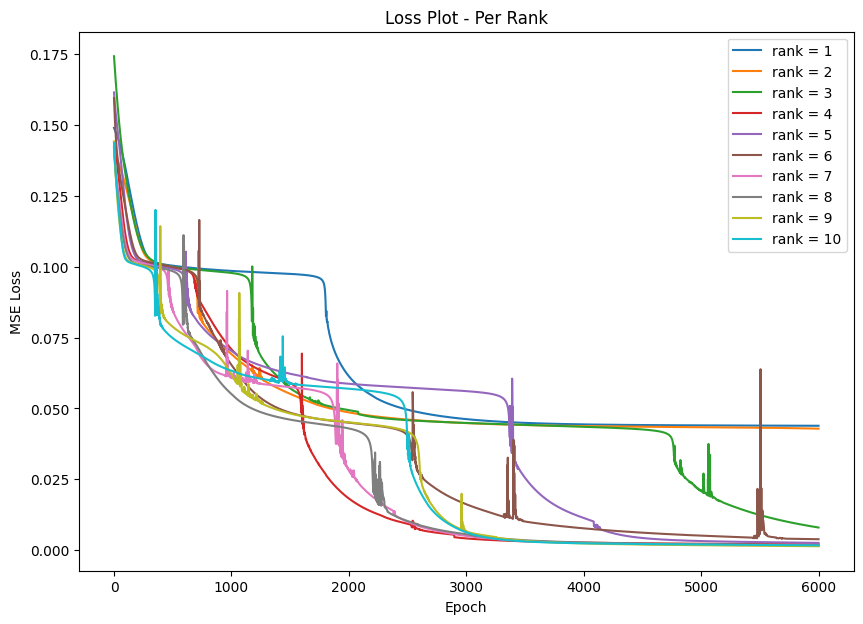

In [32]:
fig = plt.figure(figsize=(10,7))
ax = fig.add_subplot(1,1,1)
for rank in range(ranks):
  _=ax.plot(r_losses[rank],label = f'rank = {rank+1}')


_=ax.set_title("Loss Plot - Per Rank")
_=ax.set_xlabel("Epoch")
_=ax.set_ylabel("MSE Loss")
_=ax.legend()

####K=3, tanh

In [7]:
# k - flip-flop
K = 3
T = 100

# decide on hyperparameters
input_size=K
output_size=K
hidden_dim=30

full_rank_rnn = Three_Bodies_RNN(input_size,output_size,hidden_dim,nonlinearity = torch.tanh,task = "FF").to(DEVICE)
full_rank_rnn.load_state_dict(torch.load(f"/content/drive/MyDrive/Three_Bodies_Network/models/Tb_Rnn_K3_Tanh.pth"))

# MSE loss and Adam optimizer with a learning rate
criterion = nn.MSELoss().to(DEVICE)

# train parameters
n_steps = 6000
n_batch = 128
batch_size=128

Inputs, Targets = K_Bit_Flipflop_task.generate_mem_data(n_batch,T,K)

ranks = 10
r_losses = []

lr = 1e-03

for rank in range(1,ranks+1):
  # instantiate an low rank RNN
  low_rank_rnn = Low_Rank_RNN(input_size, output_size, hidden_dim, rank,nonlinearity = torch.tanh, task = "FF").to(DEVICE)
  optimizer = torch.optim.Adam(low_rank_rnn.parameters(), lr=lr)
  losses = low_rank_rnn.lr_train(Inputs,Targets,full_rank_rnn,n_steps,optimizer,criterion,batch_size,T)
  r_losses.append(losses)
  torch.save(low_rank_rnn.state_dict(), f'/content/drive/MyDrive/Three_Bodies_Network/Low_Rank_Rnn/Three_Way_Rank_{rank}_RNN_new.pth')

Output hidden; open in https://colab.research.google.com to view.

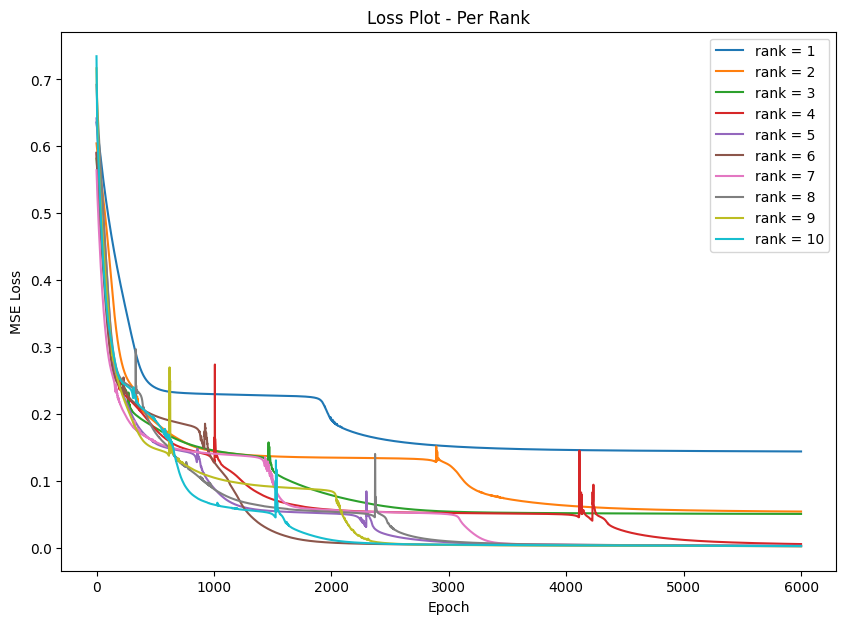

In [24]:
fig = plt.figure(figsize=(10,7))
ax = fig.add_subplot(1,1,1)
for rank in range(ranks):
  _=ax.plot(r_losses[rank],label = f'rank = {rank+1}')


_=ax.set_title("Loss Plot - Per Rank")
_=ax.set_xlabel("Epoch")
_=ax.set_ylabel("MSE Loss")
_=ax.legend()